# Homework 4 (Ibotta Products)

In [11]:
# import analysis packages
import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Embedding, Flatten, LSTM, SimpleRNN, TextVectorization
from keras.models import Sequential
from keras.regularizers import l2
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

### Data Preprocessing

In [2]:
# read data from .csv files
trainDF = pd.read_csv('./ibotta_train.csv')
testDF = pd.read_csv('./ibotta_test.csv')

In [3]:
# combine data sets for preprocessing
trainDF['origin'] = 'train'
testDF['origin'] = 'test'
fullDF = pd.concat([trainDF, testDF])

# combine name and brand name fields
fullDF['Brand_name'].where(-fullDF['Brand_name'].isna(), '', inplace = True)
fullDF['Full_text'] = fullDF['Brand_name'] + ' ' + fullDF['Name']

# seed random seed
random.seed(542023)

# split data
trainDF = pd.DataFrame(fullDF.loc[fullDF['origin'] == 'train'].drop('origin', axis = 1))
testDF = pd.DataFrame(fullDF.loc[fullDF['origin'] == 'test'].drop(['origin', 'Category'], axis = 1))

In [4]:
# check dimensions of data
display(trainDF.shape)
display(testDF.shape)

# check data types
display(trainDF.info())

# peek at data
display(trainDF.head())

(8000, 6)

(1999, 5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          8000 non-null   int64  
 1   Name        8000 non-null   object 
 2   Brand_name  8000 non-null   object 
 3   Category    8000 non-null   object 
 4   Cat_code    8000 non-null   float64
 5   Full_text   8000 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 437.5+ KB


None

,Id,Name,Brand_name,Category,Cat_code,Full_text
0,1,"4C HomeStyle Parmesan Grated Cheese, 6 oz",4C,Dairy,2.0,"4C 4C HomeStyle Parmesan Grated Cheese, 6 oz"
1,2,"4C 100% Natural Parmesan Cheese, 6 oz",,Dairy,2.0,"4C 100% Natural Parmesan Cheese, 6 oz"
2,3,"4C Parmesan & Romano Cheese, Grated",4C,Dairy,2.0,"4C 4C Parmesan & Romano Cheese, Grated"
3,4,Advance Fast Fixin' Country Fried Steaks with ...,Fast Fixin',Frozen Foods,3.0,Fast Fixin' Advance Fast Fixin' Country Fried ...
4,5,Borden: Salted 4 Ct Butter,Borden Dairy Company,Dairy,2.0,Borden Dairy Company Borden: Salted 4 Ct Butter


### Text Vectorization

In [5]:
# train integer index tokenizer
intTokenizer = TextVectorization()
intTokenizer.adapt(fullDF['Full_text'])

# vectorize text data
intVecDF = pd.DataFrame(intTokenizer(fullDF['Full_text']))
trainDFintVec = intVecDF.loc[0:7999]
testDFintVec = intVecDF.loc[8000:9999]

# data shape and form
display(trainDFintVec.shape)
display(testDFintVec.shape)
display(trainDFintVec.head())

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-05-11 15:16:45.696973: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(8000, 50)

(1999, 50)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1655,1655,515,177,730,2,135,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1655,166,44,177,2,135,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1655,1655,177,1017,2,730,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1306,2110,4599,1306,2110,119,279,954,36,923,...,0,0,0,0,0,0,0,0,0,0
4,448,72,569,448,153,128,162,35,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# train bag of words tokenizer
countTokenizer = TextVectorization(output_mode = 'multi_hot')
countTokenizer.adapt(fullDF['Full_text'])

# vectorize text data
countVecDF = pd.DataFrame(countTokenizer(fullDF['Full_text']))
trainDFcountVec = countVecDF.loc[0:7999]
testDFcountVec = countVecDF.loc[8000:9999]

# data shape and form
display(trainDFcountVec.shape)
display(testDFcountVec.shape)
display(trainDFcountVec.head())

(8000, 4880)

(1999, 4880)

,0,1,2,3,4,5,6,7,8,9,...,4870,4871,4872,4873,4874,4875,4876,4877,4878,4879
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# train truncated bag of words tokenizer
countTokenizer1000 = TextVectorization(output_mode = 'multi_hot',
                                       vocabulary = countTokenizer.get_vocabulary()[0:1000])

# vectorize text data
countVec1000DF = pd.DataFrame(countTokenizer1000(fullDF['Full_text']))
trainDFcountVec1000 = countVec1000DF.loc[0:7999]
testDFcountVec1000 = countVec1000DF.loc[8000:9999]

# data shape and form
display(trainDFcountVec1000.shape)
display(testDFcountVec1000.shape)
display(trainDFcountVec1000.head())

(8000, 1000)

(1999, 1000)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# train tfidf tokenizer
tfidfTokenizer = TextVectorization(output_mode = 'tf_idf')
tfidfTokenizer.adapt(fullDF['Full_text'])

# vectorize text data
tfidfVecDF = pd.DataFrame(tfidfTokenizer(fullDF['Full_text']))
trainDFtfidfVec = tfidfVecDF.loc[0:7999]
testDFtfidfVec = tfidfVecDF.loc[8000:9999]

# data shape and form
display(trainDFtfidfVec.shape)
display(testDFtfidfVec.shape)
display(trainDFtfidfVec.head())

(8000, 4880)

(1999, 4880)

,0,1,2,3,4,5,6,7,8,9,...,4870,4871,4872,4873,4874,4875,4876,4877,4878,4879
0,0.0,2.183039,2.183039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.183039,2.183039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.183039,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# train tfidf tokenizer
tfidfTokenizer1000 = TextVectorization(output_mode = 'tf_idf', 
                                       vocabulary = tfidfTokenizer.get_vocabulary()[0:1000],
                                       idf_weights = tfidfTokenizer.get_weights()[0][0:1000])

# vectorize text data
tfidfVec1000DF = pd.DataFrame(tfidfTokenizer1000(fullDF['Full_text']))
trainDFtfidfVec1000 = tfidfVec1000DF.loc[0:7999]
testDFtfidfVec1000 = tfidfVec1000DF.loc[8000:9999]

# data shape and form
display(trainDFtfidfVec1000.shape)
display(testDFtfidfVec1000.shape)
display(trainDFtfidfVec1000.head())

(8000, 1000)

(1999, 1000)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,15.387720,2.183039,2.183039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.693860,2.183039,2.183039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,23.081581,2.183039,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,38.469299,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model Fitting

In [10]:
# model evaluation function
def EvaluateModel(model, X_train):
    # set random seeds
    np.random.seed(542023)
    tf.random.set_seed(542023)

    # print model summary
    try:
        model.summary()
    except:
        pass

    # define F1 metric
    f1_score_metric = F1Score(num_classes = 7, average = 'weighted')

    # compile model
    model.compile(optimizer = 'rmsprop',
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy', f1_score_metric])
    
    # define early stopping criterion
    early = EarlyStopping(monitor = 'val_f1_score', mode = 'max', patience = 3)

    # train deep learning model
    trained = model.fit(X_train,
                        to_categorical(trainDF['Cat_code']),
                        epochs = 100,
                        batch_size = 128,
                        callbacks = early,
                        validation_split = 0.15,
                        verbose = 1)
    
    # prepare model evaluation
    acc = trained.history['accuracy']
    val_acc = trained.history['val_accuracy']
    loss = trained.history['loss']
    val_loss = trained.history['val_loss']
    f1_score = trained.history['f1_score']
    val_f1_score = trained.history['val_f1_score']
    epochs = range(1, len(acc) + 1)

    # final validation accuracy
    display(f"Internal validation accuracy: {round(val_acc[-1] * 100, 2)}%")
    display(f'Internal validation F1 score: {round(val_f1_score[-1], 4)}')

    # plot training accuracy
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15, 5))
    ax1.plot(epochs, acc, 'bo', label = 'Training acc')
    ax1.plot(epochs, val_acc, 'b', label = 'Validation acc')
    ax1.set(xlabel = 'Epochs', ylabel = 'Accuracy')
    ax1.legend()
    ax2.plot(epochs, loss, 'bo', label = 'Training loss')
    ax2.plot(epochs, val_loss, 'b', label = 'Validation loss')
    ax2.set(xlabel = 'Epochs', ylabel = 'Loss')
    ax2.legend()
    ax3.plot(epochs, f1_score, 'bo', label = 'Training F1')
    ax3.plot(epochs, val_f1_score, 'b', label = 'Validation F1')
    ax3.set(xlabel = 'Epochs', ylabel = 'F1 Score')
    ax3.legend()
    fig.suptitle('Evaluation Metrics')

### Basic MLP Models

Epoch 1/100
54/54 [==============================] - 2s 28ms/step - loss: 10.0328 - accuracy: 0.1562 - f1_score: 0.1624 - val_loss: 2.5869 - val_accuracy: 0.2275 - val_f1_score: 0.1635
Epoch 2/100
54/54 [==============================] - 1s 19ms/step - loss: 2.2458 - accuracy: 0.2759 - f1_score: 0.1807 - val_loss: 1.9728 - val_accuracy: 0.2442 - val_f1_score: 0.1100
Epoch 3/100
54/54 [==============================] - 1s 19ms/step - loss: 1.9156 - accuracy: 0.2993 - f1_score: 0.1484 - val_loss: 1.9036 - val_accuracy: 0.2483 - val_f1_score: 0.1008
Epoch 4/100
54/54 [==============================] - 1s 20ms/step - loss: 1.8773 - accuracy: 0.3031 - f1_score: 0.1469 - val_loss: 1.8896 - val_accuracy: 0.2492 - val_f1_score: 0.1010


'Internal validation accuracy: 24.92%'

'Internal validation F1 score: 0.101'

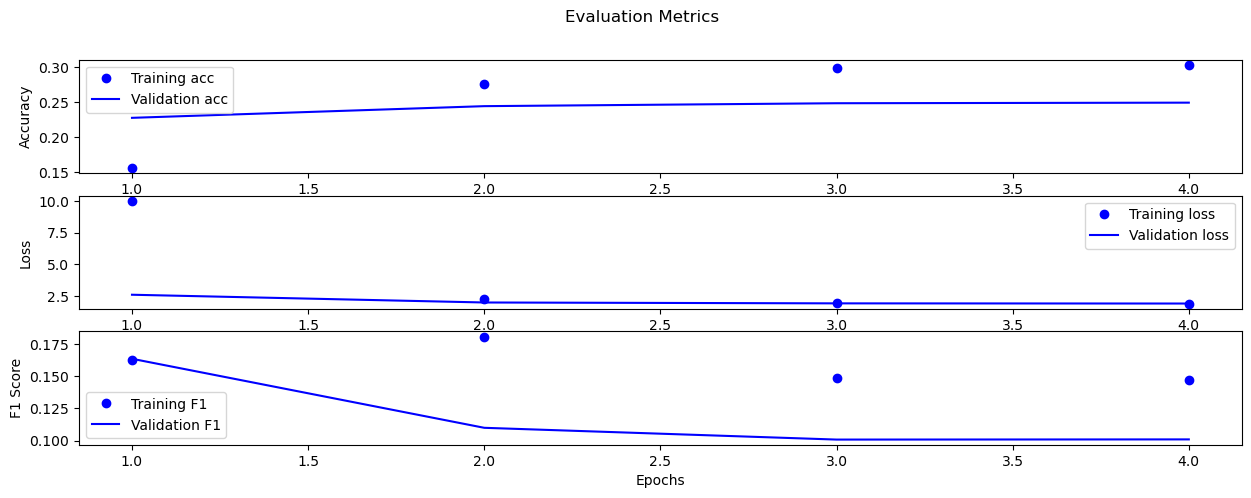

In [22]:
# define model architecture
model = Sequential([
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(16, activation = 'relu'),
    Dense(8, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Epoch 1/100
54/54 [==============================] - 2s 26ms/step - loss: 16.2898 - accuracy: 0.2165 - f1_score: 0.2221 - val_loss: 7.9667 - val_accuracy: 0.1725 - val_f1_score: 0.1168
Epoch 2/100
54/54 [==============================] - 1s 18ms/step - loss: 3.7373 - accuracy: 0.2381 - f1_score: 0.2386 - val_loss: 3.6867 - val_accuracy: 0.1350 - val_f1_score: 0.1313
Epoch 3/100
54/54 [==============================] - 1s 20ms/step - loss: 2.3913 - accuracy: 0.2772 - f1_score: 0.2611 - val_loss: 2.2663 - val_accuracy: 0.2433 - val_f1_score: 0.2166
Epoch 4/100
54/54 [==============================] - 1s 19ms/step - loss: 2.0343 - accuracy: 0.3071 - f1_score: 0.2789 - val_loss: 2.2136 - val_accuracy: 0.2158 - val_f1_score: 0.1896
Epoch 5/100
54/54 [==============================] - 1s 19ms/step - loss: 1.9569 - accuracy: 0.3272 - f1_score: 0.2841 - val_loss: 1.9488 - val_accuracy: 0.3075 - val_f1_score: 0.2487
Epoch 6/100
54/54 [==============================] - 1s 19ms/step - loss: 1.868

'Internal validation accuracy: 28.0%'

'Internal validation F1 score: 0.2344'

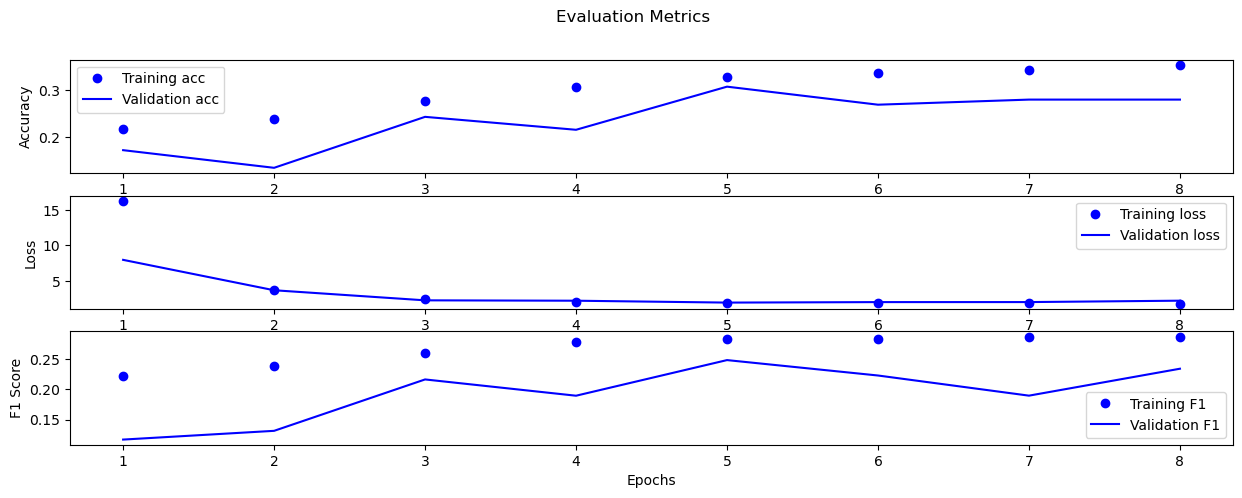

In [23]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Epoch 1/100
54/54 [==============================] - 11s 166ms/step - loss: 1.6933 - accuracy: 0.3222 - f1_score: 0.1998 - val_loss: 1.4226 - val_accuracy: 0.4175 - val_f1_score: 0.3514
Epoch 2/100
54/54 [==============================] - 3s 63ms/step - loss: 0.9898 - accuracy: 0.5538 - f1_score: 0.4745 - val_loss: 0.8276 - val_accuracy: 0.6683 - val_f1_score: 0.6446
Epoch 3/100
54/54 [==============================] - 3s 62ms/step - loss: 0.4719 - accuracy: 0.8731 - f1_score: 0.8685 - val_loss: 0.4815 - val_accuracy: 0.8633 - val_f1_score: 0.8600
Epoch 4/100
54/54 [==============================] - 3s 57ms/step - loss: 0.1923 - accuracy: 0.9610 - f1_score: 0.9607 - val_loss: 0.3487 - val_accuracy: 0.9067 - val_f1_score: 0.9072
Epoch 5/100
54/54 [==============================] - 4s 67ms/step - loss: 0.1124 - accuracy: 0.9775 - f1_score: 0.9775 - val_loss: 0.3436 - val_accuracy: 0.9058 - val_f1_score: 0.9056
Epoch 6/100
54/54 [==============================] - 3s 63ms/step - loss: 0.07

'Internal validation accuracy: 91.0%'

'Internal validation F1 score: 0.9104'

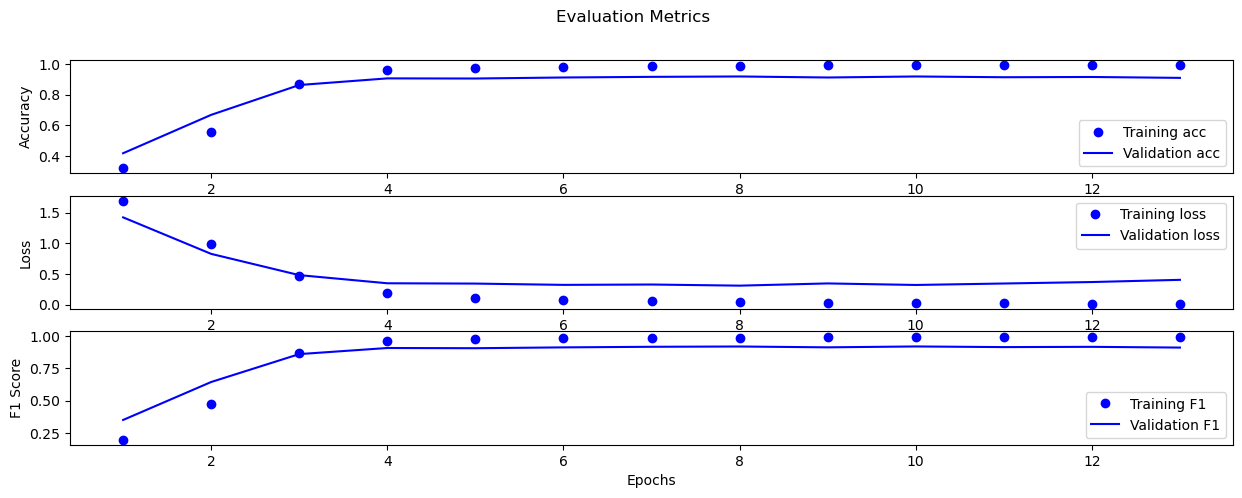

In [73]:
# define model architecture
model = Sequential([
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(16, activation = 'relu'),
    Dense(8, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFcountVec)

Epoch 1/100
54/54 [==============================] - 12s 169ms/step - loss: 0.7105 - accuracy: 0.7579 - f1_score: 0.7537 - val_loss: 0.4887 - val_accuracy: 0.8558 - val_f1_score: 0.8535
Epoch 2/100
54/54 [==============================] - 4s 74ms/step - loss: 0.1037 - accuracy: 0.9746 - f1_score: 0.9746 - val_loss: 0.4226 - val_accuracy: 0.8733 - val_f1_score: 0.8777
Epoch 3/100
54/54 [==============================] - 3s 49ms/step - loss: 0.0434 - accuracy: 0.9875 - f1_score: 0.9875 - val_loss: 0.3467 - val_accuracy: 0.9125 - val_f1_score: 0.9127
Epoch 4/100
54/54 [==============================] - 2s 42ms/step - loss: 0.0261 - accuracy: 0.9913 - f1_score: 0.9913 - val_loss: 0.3629 - val_accuracy: 0.9125 - val_f1_score: 0.9129
Epoch 5/100
54/54 [==============================] - 2s 46ms/step - loss: 0.0129 - accuracy: 0.9954 - f1_score: 0.9954 - val_loss: 0.5252 - val_accuracy: 0.8975 - val_f1_score: 0.8981
Epoch 6/100
54/54 [==============================] - 3s 48ms/step - loss: 0.01

'Internal validation accuracy: 91.5%'

'Internal validation F1 score: 0.9149'

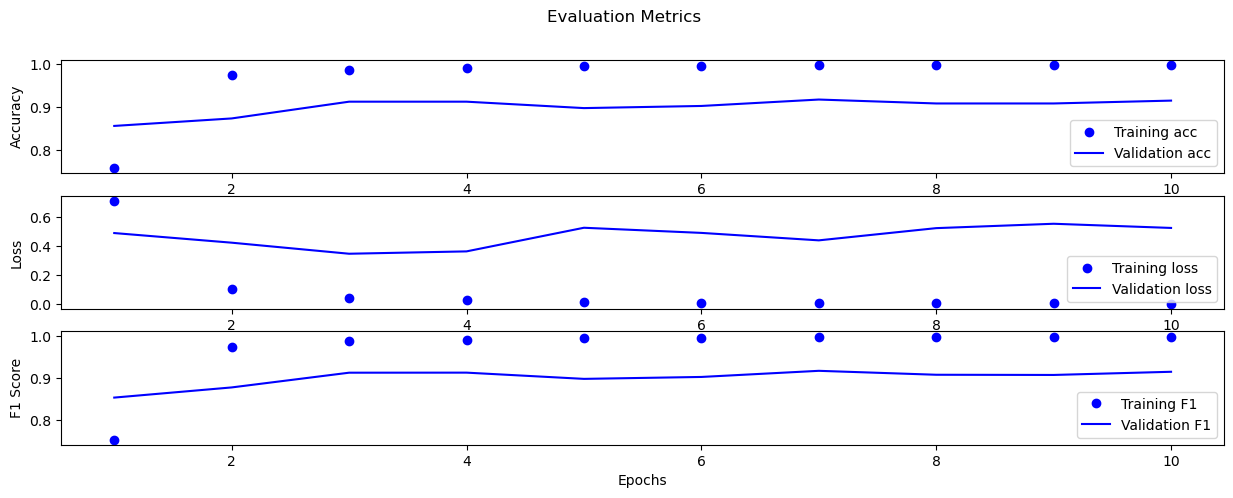

In [74]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFcountVec)

Epoch 1/100
54/54 [==============================] - 10s 134ms/step - loss: 0.7813 - accuracy: 0.7400 - f1_score: 0.7335 - val_loss: 0.5295 - val_accuracy: 0.8375 - val_f1_score: 0.8376
Epoch 2/100
54/54 [==============================] - 3s 46ms/step - loss: 0.1749 - accuracy: 0.9451 - f1_score: 0.9452 - val_loss: 0.4892 - val_accuracy: 0.8492 - val_f1_score: 0.8574
Epoch 3/100
54/54 [==============================] - 3s 47ms/step - loss: 0.1050 - accuracy: 0.9662 - f1_score: 0.9662 - val_loss: 0.3742 - val_accuracy: 0.8992 - val_f1_score: 0.8995
Epoch 4/100
54/54 [==============================] - 2s 42ms/step - loss: 0.0720 - accuracy: 0.9768 - f1_score: 0.9768 - val_loss: 0.3934 - val_accuracy: 0.8850 - val_f1_score: 0.8837
Epoch 5/100
54/54 [==============================] - 2s 42ms/step - loss: 0.0582 - accuracy: 0.9791 - f1_score: 0.9791 - val_loss: 0.3998 - val_accuracy: 0.9017 - val_f1_score: 0.9036
Epoch 6/100
54/54 [==============================] - 2s 38ms/step - loss: 0.04

'Internal validation accuracy: 90.0%'

'Internal validation F1 score: 0.9002'

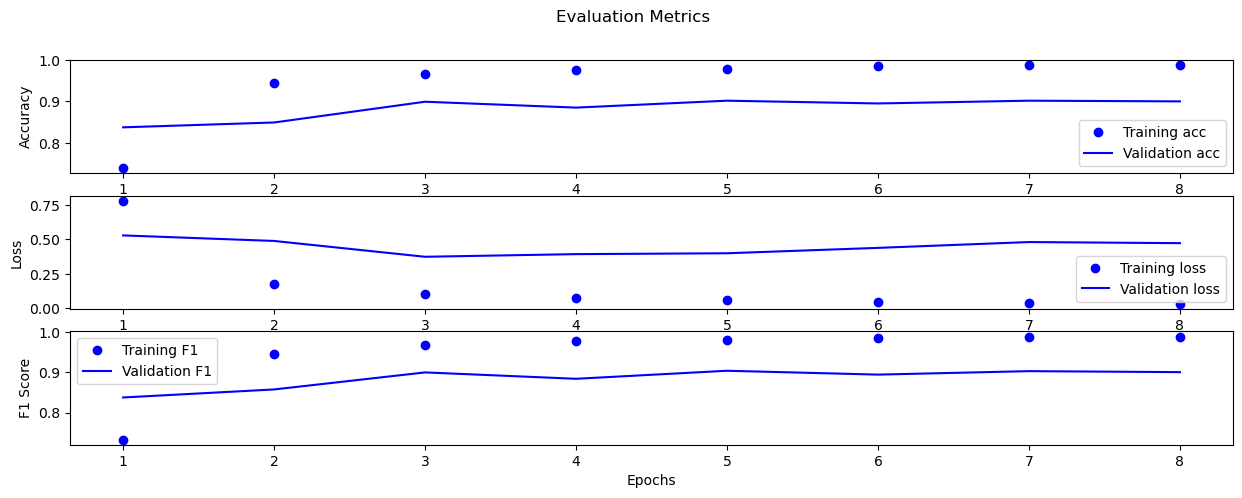

In [75]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFcountVec1000)

Epoch 1/100
54/54 [==============================] - 17s 256ms/step - loss: 0.7768 - accuracy: 0.7391 - f1_score: 0.7299 - val_loss: 0.3809 - val_accuracy: 0.8792 - val_f1_score: 0.8796
Epoch 2/100
54/54 [==============================] - 8s 145ms/step - loss: 0.1031 - accuracy: 0.9722 - f1_score: 0.9722 - val_loss: 0.3759 - val_accuracy: 0.8833 - val_f1_score: 0.8832
Epoch 3/100
54/54 [==============================] - 7s 123ms/step - loss: 0.0405 - accuracy: 0.9884 - f1_score: 0.9884 - val_loss: 0.4440 - val_accuracy: 0.9067 - val_f1_score: 0.9056
Epoch 4/100
54/54 [==============================] - 6s 112ms/step - loss: 0.0289 - accuracy: 0.9916 - f1_score: 0.9916 - val_loss: 0.4183 - val_accuracy: 0.9100 - val_f1_score: 0.9091
Epoch 5/100
54/54 [==============================] - 6s 109ms/step - loss: 0.0131 - accuracy: 0.9963 - f1_score: 0.9963 - val_loss: 0.4789 - val_accuracy: 0.9108 - val_f1_score: 0.9116
Epoch 6/100
54/54 [==============================] - 6s 113ms/step - loss:

'Internal validation accuracy: 90.58%'

'Internal validation F1 score: 0.9058'

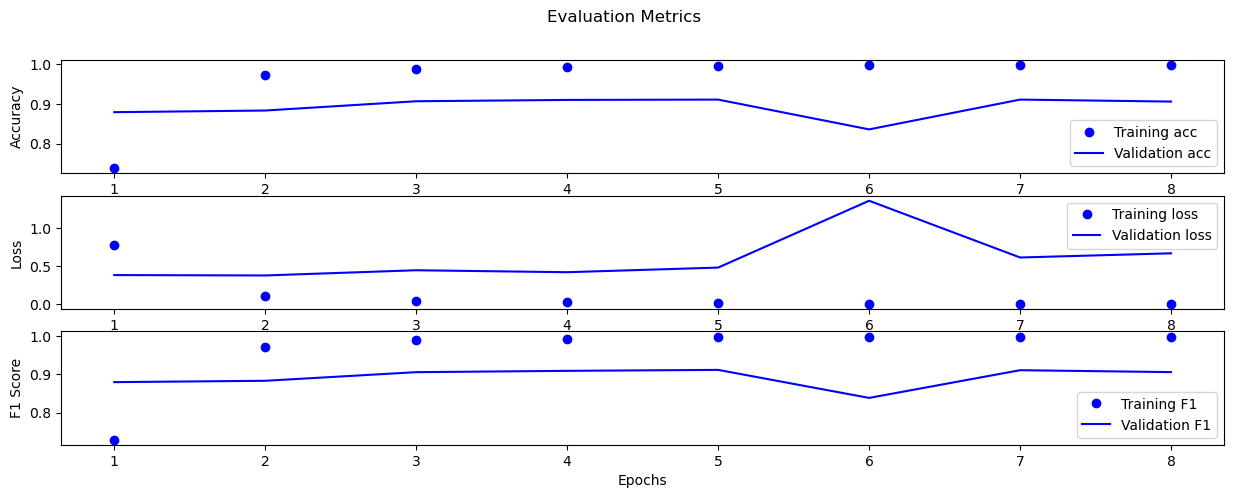

In [76]:
# define model architecture
model = Sequential([
    Dense(2048, activation = 'relu'),
    Dense(1024, activation = 'relu'),
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFcountVec)

Epoch 1/100
54/54 [==============================] - 20s 297ms/step - loss: 2.3787 - accuracy: 0.6218 - f1_score: 0.5842 - val_loss: 1.2953 - val_accuracy: 0.7442 - val_f1_score: 0.7237
Epoch 2/100
54/54 [==============================] - 7s 138ms/step - loss: 0.7848 - accuracy: 0.9185 - f1_score: 0.9183 - val_loss: 1.0380 - val_accuracy: 0.7900 - val_f1_score: 0.7920
Epoch 3/100
54/54 [==============================] - 7s 125ms/step - loss: 0.5393 - accuracy: 0.9512 - f1_score: 0.9512 - val_loss: 0.7358 - val_accuracy: 0.8883 - val_f1_score: 0.8894
Epoch 4/100
54/54 [==============================] - 7s 130ms/step - loss: 0.4490 - accuracy: 0.9563 - f1_score: 0.9564 - val_loss: 1.2570 - val_accuracy: 0.6617 - val_f1_score: 0.6740
Epoch 5/100
54/54 [==============================] - 7s 125ms/step - loss: 0.3779 - accuracy: 0.9631 - f1_score: 0.9631 - val_loss: 0.6953 - val_accuracy: 0.8592 - val_f1_score: 0.8582
Epoch 6/100
54/54 [==============================] - 7s 128ms/step - loss:

'Internal validation accuracy: 84.58%'

'Internal validation F1 score: 0.8481'

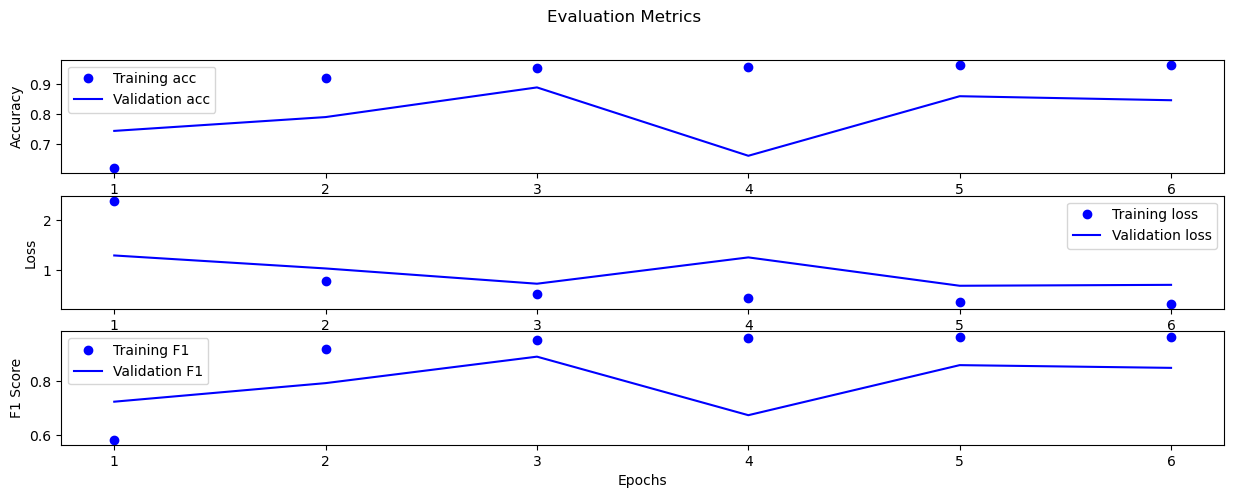

In [77]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(2048, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(1024, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFcountVec)

Epoch 1/100
54/54 [==============================] - 12s 175ms/step - loss: 1.3799 - accuracy: 0.7381 - f1_score: 0.7306 - val_loss: 1.0170 - val_accuracy: 0.8367 - val_f1_score: 0.8391
Epoch 2/100
54/54 [==============================] - 4s 80ms/step - loss: 0.5664 - accuracy: 0.9546 - f1_score: 0.9546 - val_loss: 0.9133 - val_accuracy: 0.8292 - val_f1_score: 0.8293
Epoch 3/100
54/54 [==============================] - 4s 77ms/step - loss: 0.4403 - accuracy: 0.9668 - f1_score: 0.9668 - val_loss: 0.7010 - val_accuracy: 0.8700 - val_f1_score: 0.8714
Epoch 4/100
54/54 [==============================] - 4s 76ms/step - loss: 0.3677 - accuracy: 0.9688 - f1_score: 0.9688 - val_loss: 0.5884 - val_accuracy: 0.8975 - val_f1_score: 0.8955
Epoch 5/100
54/54 [==============================] - 4s 73ms/step - loss: 0.3266 - accuracy: 0.9712 - f1_score: 0.9712 - val_loss: 0.5542 - val_accuracy: 0.8925 - val_f1_score: 0.8933
Epoch 6/100
54/54 [==============================] - 4s 72ms/step - loss: 0.29

'Internal validation accuracy: 88.33%'

'Internal validation F1 score: 0.8846'

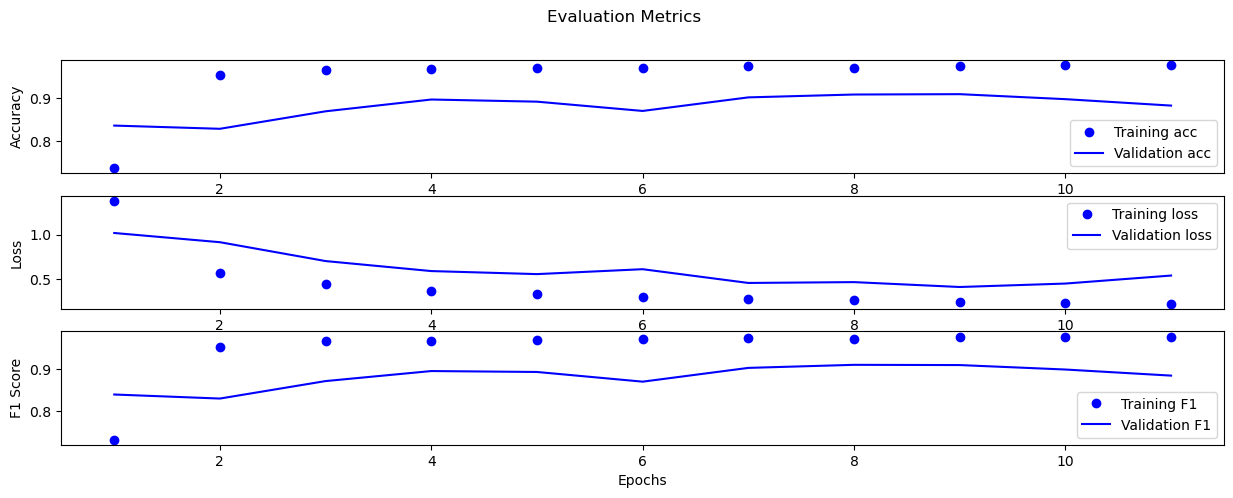

In [78]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFcountVec)

Epoch 1/100
54/54 [==============================] - 3s 36ms/step - loss: 0.6398 - accuracy: 0.7946 - f1_score: 0.7921 - val_loss: 0.5303 - val_accuracy: 0.8633 - val_f1_score: 0.8642
Epoch 2/100
54/54 [==============================] - 1s 23ms/step - loss: 0.0744 - accuracy: 0.9803 - f1_score: 0.9803 - val_loss: 0.4332 - val_accuracy: 0.8858 - val_f1_score: 0.8908
Epoch 3/100
54/54 [==============================] - 1s 23ms/step - loss: 0.0249 - accuracy: 0.9912 - f1_score: 0.9912 - val_loss: 0.5474 - val_accuracy: 0.8858 - val_f1_score: 0.8861
Epoch 4/100
54/54 [==============================] - 1s 22ms/step - loss: 0.0145 - accuracy: 0.9950 - f1_score: 0.9950 - val_loss: 0.5088 - val_accuracy: 0.8875 - val_f1_score: 0.8884
Epoch 5/100
54/54 [==============================] - 1s 22ms/step - loss: 0.0091 - accuracy: 0.9968 - f1_score: 0.9968 - val_loss: 0.5020 - val_accuracy: 0.9142 - val_f1_score: 0.9137
Epoch 6/100
54/54 [==============================] - 1s 21ms/step - loss: 0.0056

'Internal validation accuracy: 91.17%'

'Internal validation F1 score: 0.911'

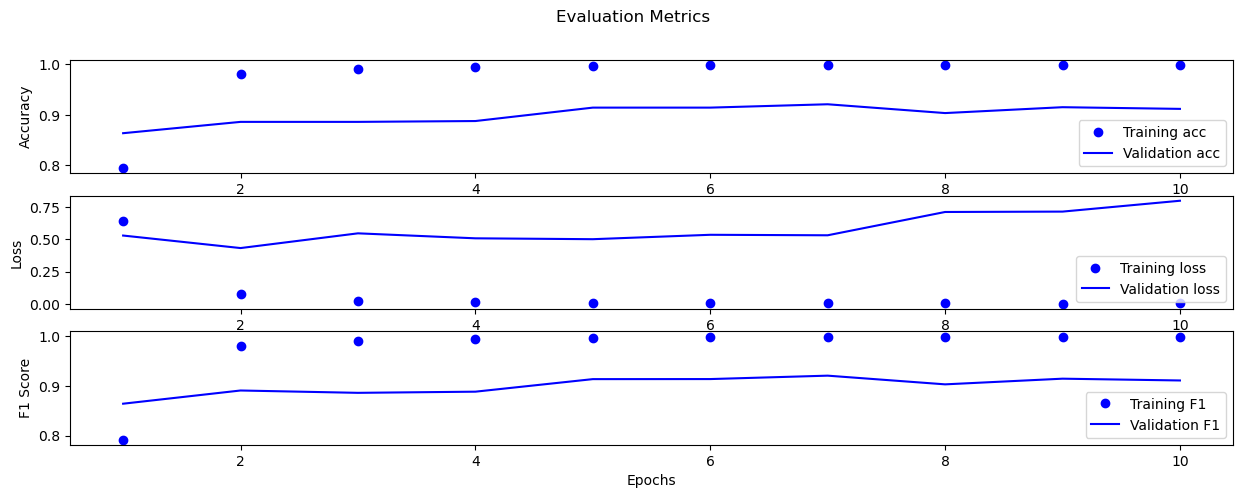

In [30]:
# define model architecture
model = Sequential([
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtfidfVec)

Epoch 1/100
54/54 [==============================] - 3s 48ms/step - loss: 0.8911 - accuracy: 0.6846 - f1_score: 0.6771 - val_loss: 0.5164 - val_accuracy: 0.8317 - val_f1_score: 0.8344
Epoch 2/100
54/54 [==============================] - 2s 39ms/step - loss: 0.1157 - accuracy: 0.9672 - f1_score: 0.9672 - val_loss: 0.4395 - val_accuracy: 0.8658 - val_f1_score: 0.8682
Epoch 3/100
54/54 [==============================] - 2s 38ms/step - loss: 0.0423 - accuracy: 0.9875 - f1_score: 0.9875 - val_loss: 0.4500 - val_accuracy: 0.9142 - val_f1_score: 0.9138
Epoch 4/100
54/54 [==============================] - 2s 43ms/step - loss: 0.0358 - accuracy: 0.9887 - f1_score: 0.9887 - val_loss: 0.5669 - val_accuracy: 0.9025 - val_f1_score: 0.9031
Epoch 5/100
54/54 [==============================] - 2s 43ms/step - loss: 0.0162 - accuracy: 0.9960 - f1_score: 0.9960 - val_loss: 0.4892 - val_accuracy: 0.9058 - val_f1_score: 0.9061
Epoch 6/100
54/54 [==============================] - 2s 40ms/step - loss: 0.0129

'Internal validation accuracy: 89.67%'

'Internal validation F1 score: 0.8983'

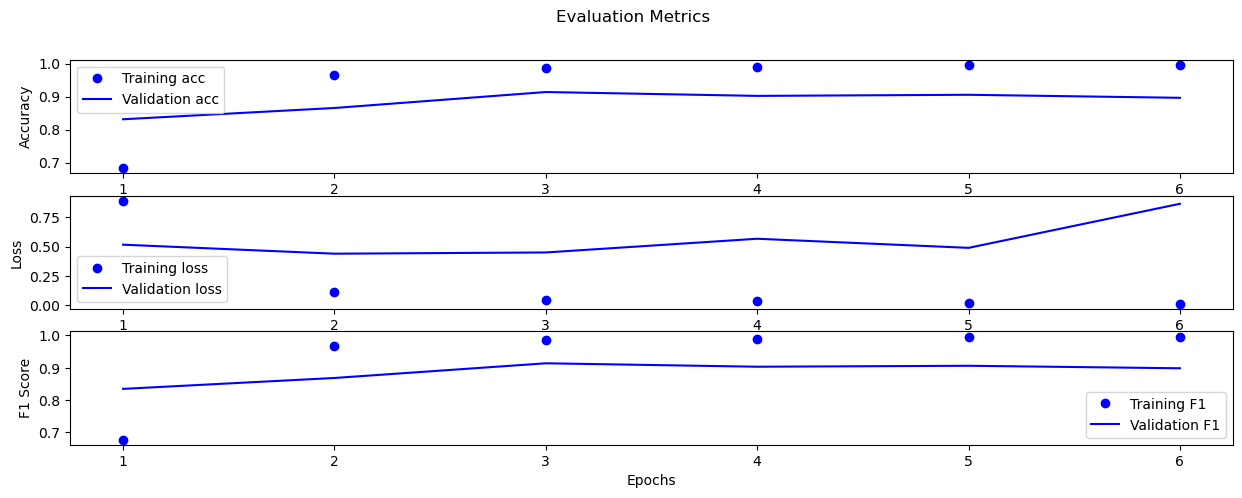

In [31]:
# define model architecture
model = Sequential([
    Dense(2048, activation = 'relu'),
    Dense(1024, activation = 'relu'),
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtfidfVec)

Epoch 1/100
54/54 [==============================] - 4s 62ms/step - loss: 2.8483 - accuracy: 0.6785 - f1_score: 0.6644 - val_loss: 1.4636 - val_accuracy: 0.8625 - val_f1_score: 0.8620
Epoch 2/100
54/54 [==============================] - 3s 52ms/step - loss: 0.8866 - accuracy: 0.9491 - f1_score: 0.9491 - val_loss: 0.9958 - val_accuracy: 0.8583 - val_f1_score: 0.8632
Epoch 3/100
54/54 [==============================] - 3s 48ms/step - loss: 0.5541 - accuracy: 0.9587 - f1_score: 0.9588 - val_loss: 0.7551 - val_accuracy: 0.8792 - val_f1_score: 0.8798
Epoch 4/100
54/54 [==============================] - 3s 48ms/step - loss: 0.4103 - accuracy: 0.9643 - f1_score: 0.9642 - val_loss: 0.6131 - val_accuracy: 0.8833 - val_f1_score: 0.8837
Epoch 5/100
54/54 [==============================] - 3s 48ms/step - loss: 0.3375 - accuracy: 0.9696 - f1_score: 0.9695 - val_loss: 0.5808 - val_accuracy: 0.8967 - val_f1_score: 0.8970
Epoch 6/100
54/54 [==============================] - 3s 48ms/step - loss: 0.2984

'Internal validation accuracy: 90.25%'

'Internal validation F1 score: 0.9045'

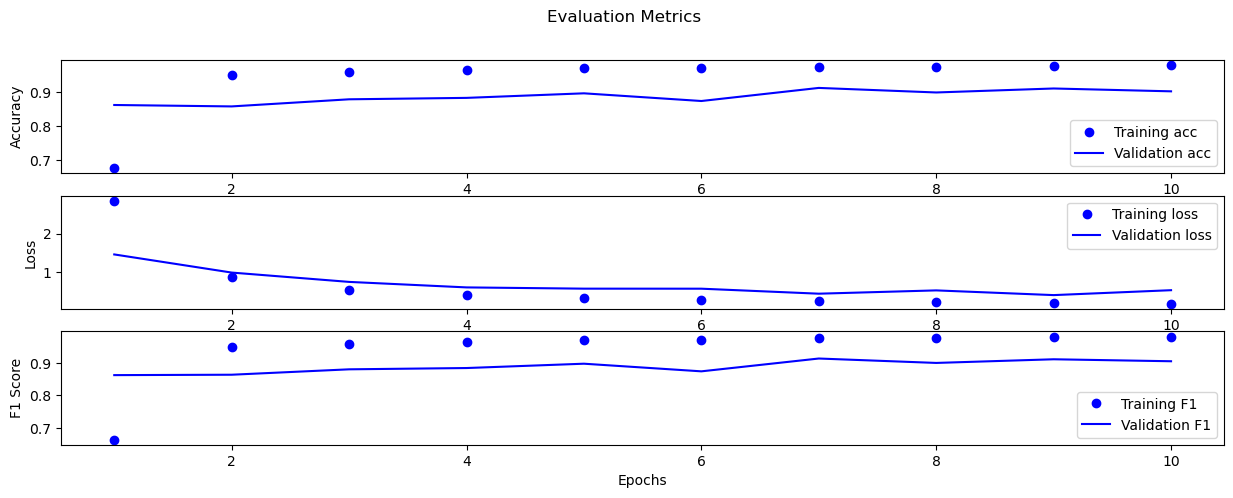

In [32]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(2048, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(1024, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtfidfVec)

Epoch 1/100
54/54 [==============================] - 3s 38ms/step - loss: 1.3166 - accuracy: 0.8025 - f1_score: 0.8001 - val_loss: 0.9682 - val_accuracy: 0.8858 - val_f1_score: 0.8863
Epoch 2/100
54/54 [==============================] - 1s 25ms/step - loss: 0.5783 - accuracy: 0.9704 - f1_score: 0.9704 - val_loss: 0.8316 - val_accuracy: 0.8733 - val_f1_score: 0.8791
Epoch 3/100
54/54 [==============================] - 1s 25ms/step - loss: 0.4287 - accuracy: 0.9765 - f1_score: 0.9765 - val_loss: 0.6495 - val_accuracy: 0.8983 - val_f1_score: 0.8991
Epoch 4/100
54/54 [==============================] - 1s 25ms/step - loss: 0.3489 - accuracy: 0.9751 - f1_score: 0.9751 - val_loss: 0.5379 - val_accuracy: 0.9058 - val_f1_score: 0.9053
Epoch 5/100
54/54 [==============================] - 1s 25ms/step - loss: 0.2906 - accuracy: 0.9782 - f1_score: 0.9782 - val_loss: 0.5770 - val_accuracy: 0.8850 - val_f1_score: 0.8856
Epoch 6/100
54/54 [==============================] - 1s 25ms/step - loss: 0.2521

'Internal validation accuracy: 89.58%'

'Internal validation F1 score: 0.8966'

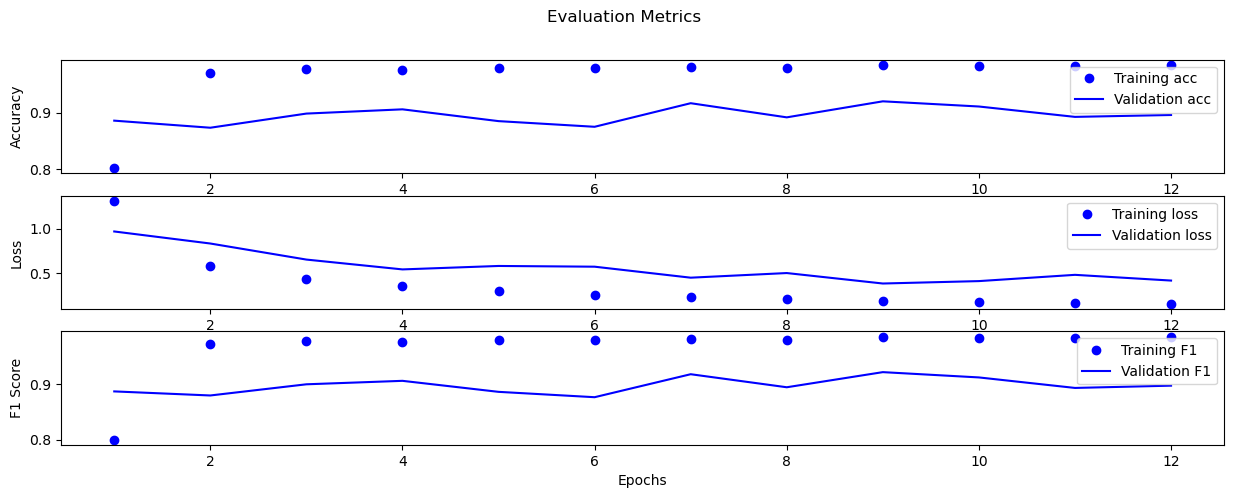

In [33]:
# define model hyperparameters
PENALTY = 0.001
RATE = 0.2

# define model architecture
model = Sequential([
    Dense(512, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dropout(RATE),
    Dense(256, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(128, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(64, kernel_regularizer = l2(PENALTY), activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtfidfVec)

### Embeddings

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 8)             400       
                                                                 
 flatten_1 (Flatten)         (None, 400)               0         
                                                                 
 dense_69 (Dense)            (None, 7)                 2807      
                                                                 
Total params: 3,207
Trainable params: 3,207
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
54/54 [==============================] - 3s 53ms/step - loss: 1.7769 - accuracy: 0.3009 - f1_score: 0.1488 - val_loss: 1.8241 - val_accuracy: 0.2925 - val_f1_score: 0.1841
Epoch 2/100
54/54 [==============================] - 2s 41ms/step - loss: 1.7209 - accuracy: 0.3434 - f1_score: 0.2307 - val_loss: 

'Internal validation accuracy: 67.58%'

'Internal validation F1 score: 0.6819'

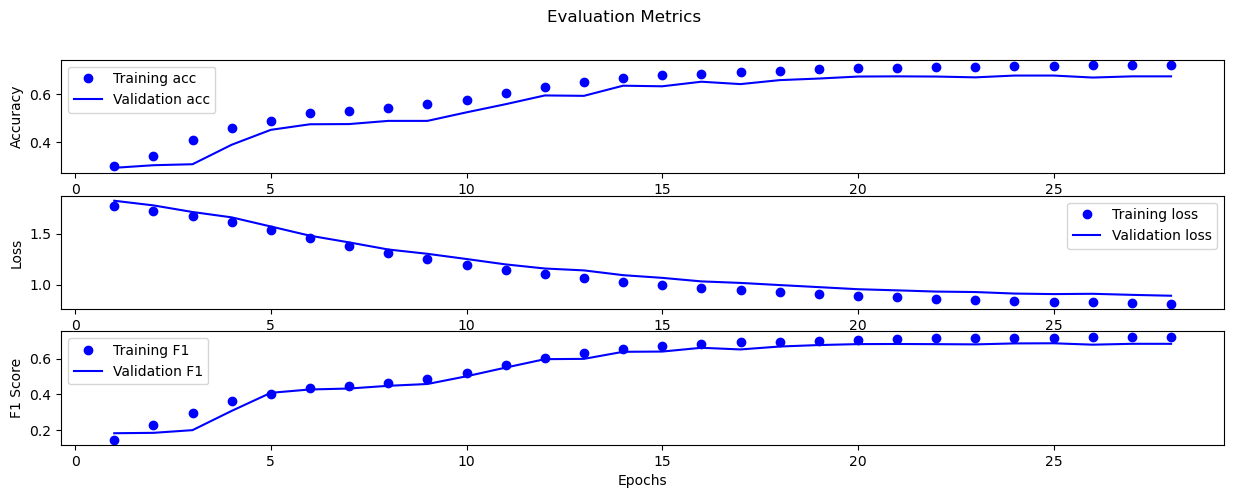

In [35]:
# define model architecture
model = Sequential([
    Embedding(50, 8, input_shape = (50, )),
    Flatten(),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 8)             400       
                                                                 
 flatten_2 (Flatten)         (None, 400)               0         
                                                                 
 dense_70 (Dense)            (None, 8)                 3208      
                                                                 
 dense_71 (Dense)            (None, 7)                 63        
                                                                 
Total params: 3,671
Trainable params: 3,671
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
54/54 [==============================] - 4s 67ms/step - loss: 1.8218 - accuracy: 0.2725 - f1_score: 0.1244 - val_loss: 1.8976 - val_accuracy: 0.2192 - val_f1_score: 0.0788

'Internal validation accuracy: 65.5%'

'Internal validation F1 score: 0.6468'

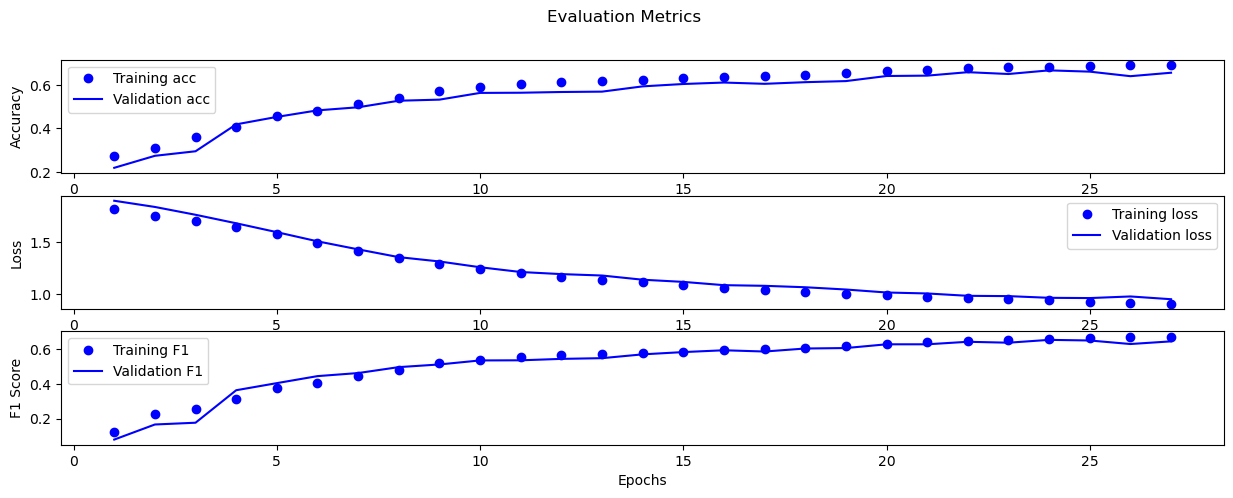

In [36]:
# define model architecture
model = Sequential([
    Embedding(50, 8, input_shape = (50, )),
    Flatten(),
    Dense(8, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 64)            3200      
                                                                 
 flatten_3 (Flatten)         (None, 3200)              0         
                                                                 
 dense_72 (Dense)            (None, 128)               409728    
                                                                 
 dense_73 (Dense)            (None, 64)                8256      
                                                                 
 dense_74 (Dense)            (None, 7)                 455       
                                                                 
Total params: 421,639
Trainable params: 421,639
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
54/54 [============================

'Internal validation accuracy: 68.17%'

'Internal validation F1 score: 0.6959'

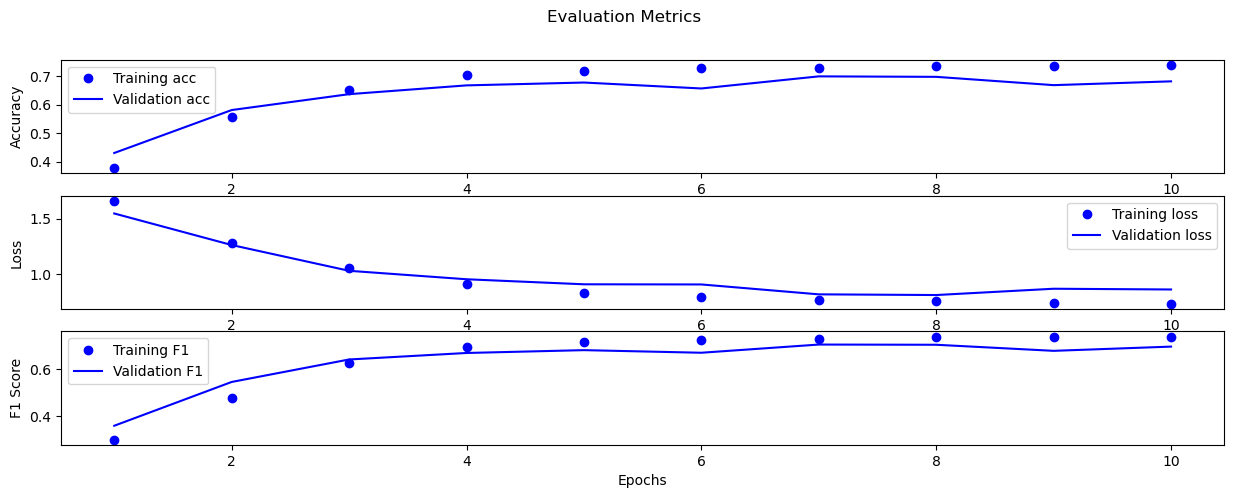

In [37]:
# define model architecture
model = Sequential([
    Embedding(50, 64, input_shape = (50, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 128)           6400      
                                                                 
 flatten_4 (Flatten)         (None, 6400)              0         
                                                                 
 dense_75 (Dense)            (None, 128)               819328    
                                                                 
 dense_76 (Dense)            (None, 64)                8256      
                                                                 
 dense_77 (Dense)            (None, 7)                 455       
                                                                 
Total params: 834,439
Trainable params: 834,439
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
54/54 [============================

'Internal validation accuracy: 65.08%'

'Internal validation F1 score: 0.665'

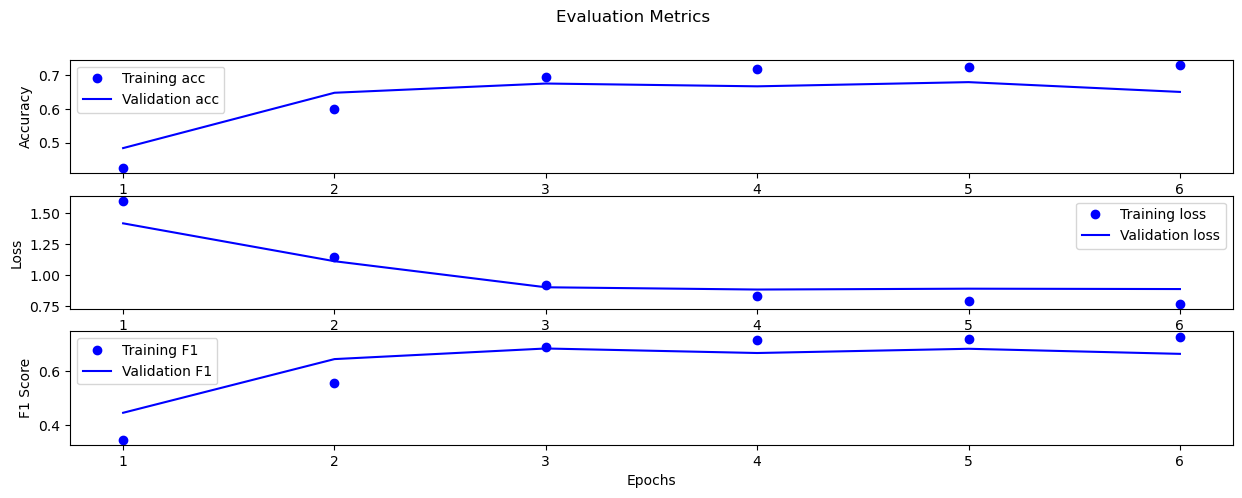

In [38]:
# define model architecture
model = Sequential([
    Embedding(50, 128, input_shape = (50, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 256)           12800     
                                                                 
 flatten_5 (Flatten)         (None, 12800)             0         
                                                                 
 dense_78 (Dense)            (None, 256)               3277056   
                                                                 
 dense_79 (Dense)            (None, 128)               32896     
                                                                 
 dense_80 (Dense)            (None, 64)                8256      
                                                                 
 dense_81 (Dense)            (None, 7)                 455       
                                                                 
Total params: 3,331,463
Trainable params: 3,331,463
N

'Internal validation accuracy: 65.0%'

'Internal validation F1 score: 0.6644'

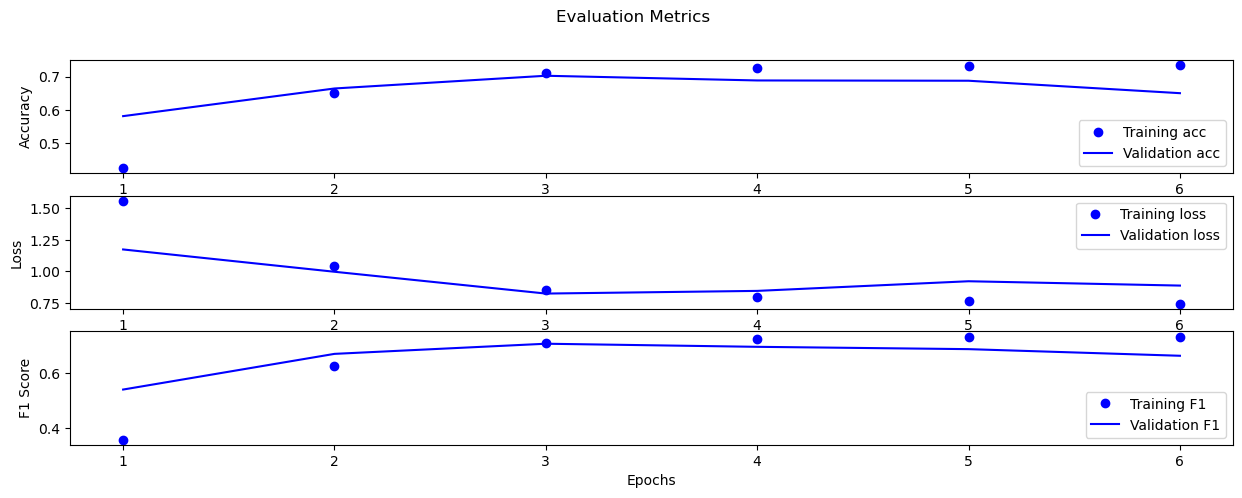

In [39]:
# define model architecture
model = Sequential([
    Embedding(50, 256, input_shape = (50, )),
    Flatten(),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 1024)          51200     
                                                                 
 flatten_6 (Flatten)         (None, 51200)             0         
                                                                 
 dense_82 (Dense)            (None, 512)               26214912  
                                                                 
 dense_83 (Dense)            (None, 256)               131328    
                                                                 
 dense_84 (Dense)            (None, 128)               32896     
                                                                 
 dense_85 (Dense)            (None, 64)                8256      
                                                                 
 dense_86 (Dense)            (None, 7)               

'Internal validation accuracy: 66.42%'

'Internal validation F1 score: 0.6592'

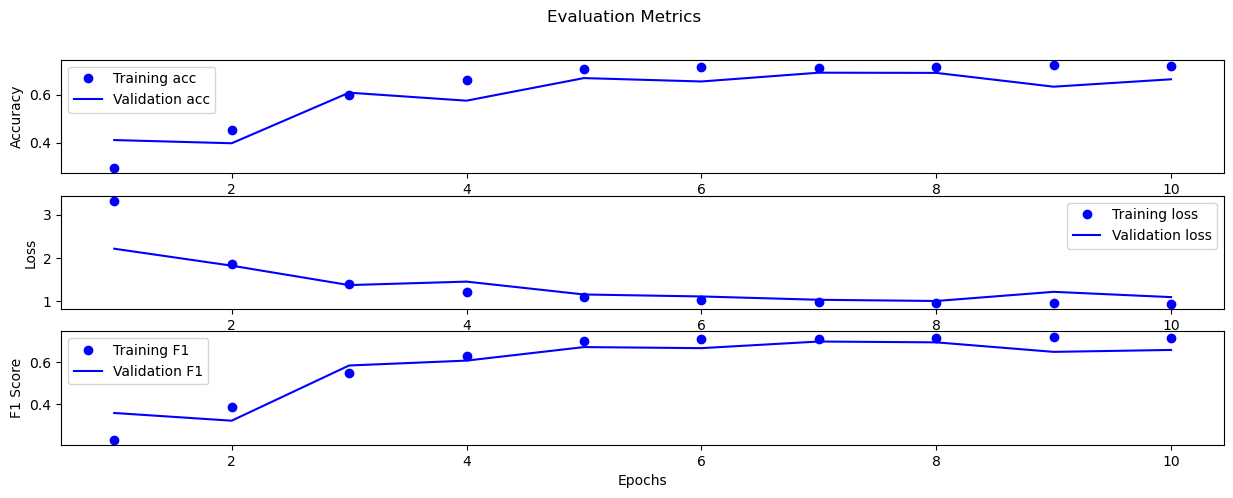

In [40]:
# define model hyperparameters
PENALTY = 0.005

# define model architecture
model = Sequential([
    Embedding(50, 1024, input_shape = (50, )),
    Flatten(),
    Dense(512, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(256, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 4880, 64)          312320    
                                                                 
 flatten_20 (Flatten)        (None, 312320)            0         
                                                                 
 dense_176 (Dense)           (None, 128)               39977088  
                                                                 
 dense_177 (Dense)           (None, 64)                8256      
                                                                 
 dense_178 (Dense)           (None, 7)                 455       
                                                                 
Total params: 40,298,119
Trainable params: 40,298,119
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
54/54 [======================

'Internal validation accuracy: 91.25%'

'Internal validation F1 score: 0.9122'

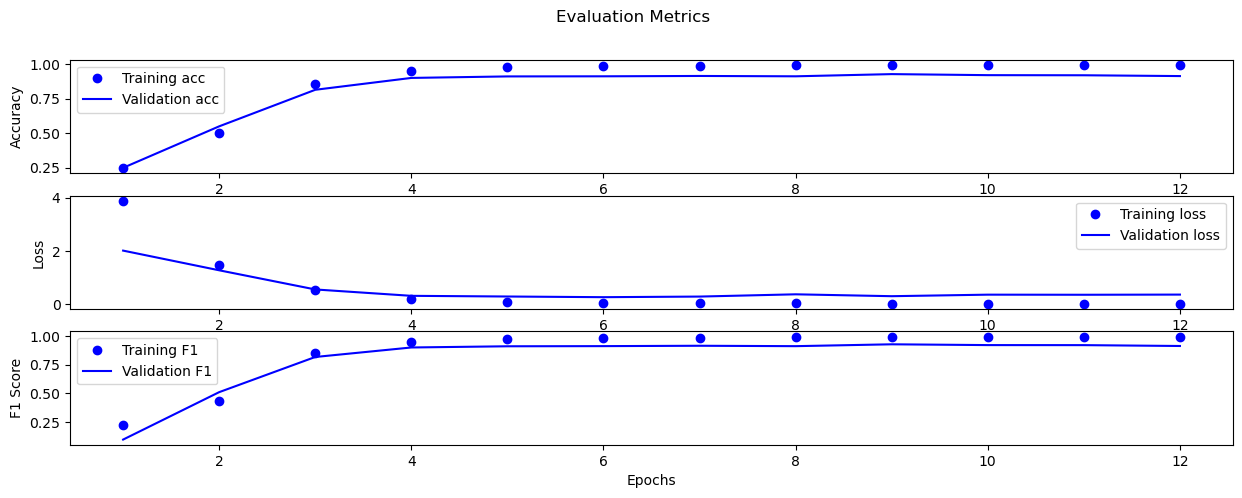

In [79]:
# define model architecture
model = Sequential([
    Embedding(4880, 64, input_shape = (4880, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFcountVec)

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 1000, 8)           8000      
                                                                 
 flatten_21 (Flatten)        (None, 8000)              0         
                                                                 
 dense_179 (Dense)           (None, 128)               1024128   
                                                                 
 dense_180 (Dense)           (None, 64)                8256      
                                                                 
 dense_181 (Dense)           (None, 7)                 455       
                                                                 
Total params: 1,040,839
Trainable params: 1,040,839
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
54/54 [========================

'Internal validation accuracy: 91.0%'

'Internal validation F1 score: 0.9094'

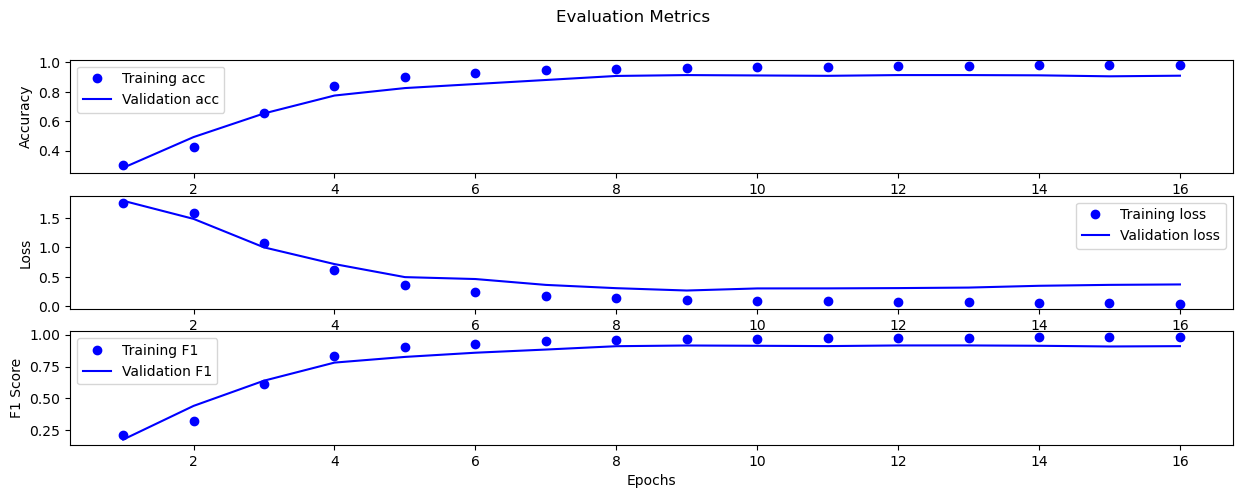

In [80]:
# define model architecture
model = Sequential([
    Embedding(1000, 8, input_shape = (1000, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFcountVec1000)

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 1000, 16)          16000     
                                                                 
 flatten_22 (Flatten)        (None, 16000)             0         
                                                                 
 dense_182 (Dense)           (None, 128)               2048128   
                                                                 
 dense_183 (Dense)           (None, 64)                8256      
                                                                 
 dense_184 (Dense)           (None, 7)                 455       
                                                                 
Total params: 2,072,839
Trainable params: 2,072,839
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
54/54 [========================

'Internal validation accuracy: 21.92%'

'Internal validation F1 score: 0.0788'

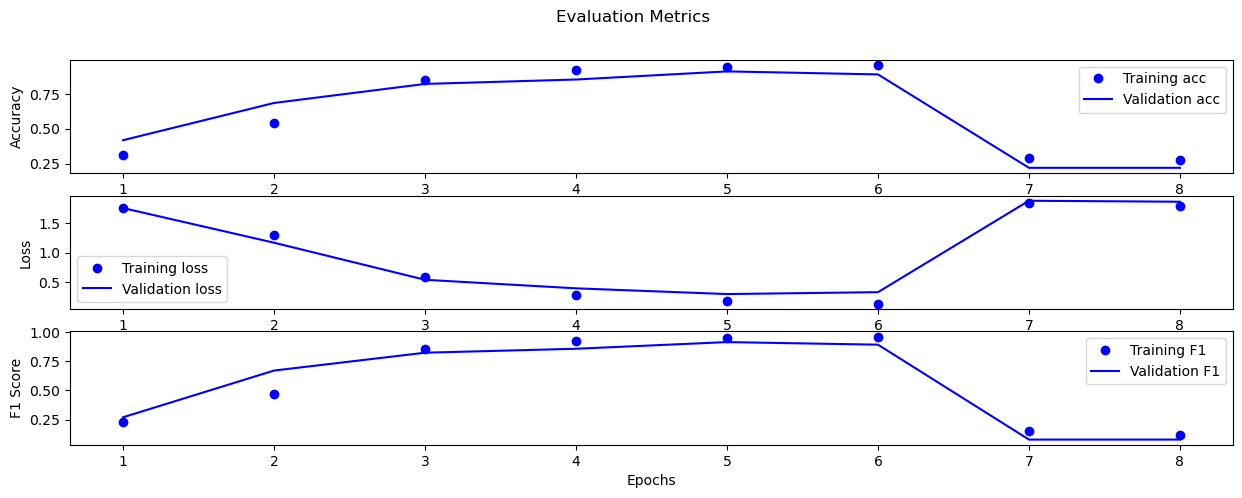

In [81]:
# define model architecture
model = Sequential([
    Embedding(1000, 16, input_shape = (1000, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFcountVec1000)

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 1000, 32)          32000     
                                                                 
 flatten_23 (Flatten)        (None, 32000)             0         
                                                                 
 dense_185 (Dense)           (None, 128)               4096128   
                                                                 
 dense_186 (Dense)           (None, 64)                8256      
                                                                 
 dense_187 (Dense)           (None, 7)                 455       
                                                                 
Total params: 4,136,839
Trainable params: 4,136,839
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
54/54 [========================

'Internal validation accuracy: 90.08%'

'Internal validation F1 score: 0.9021'

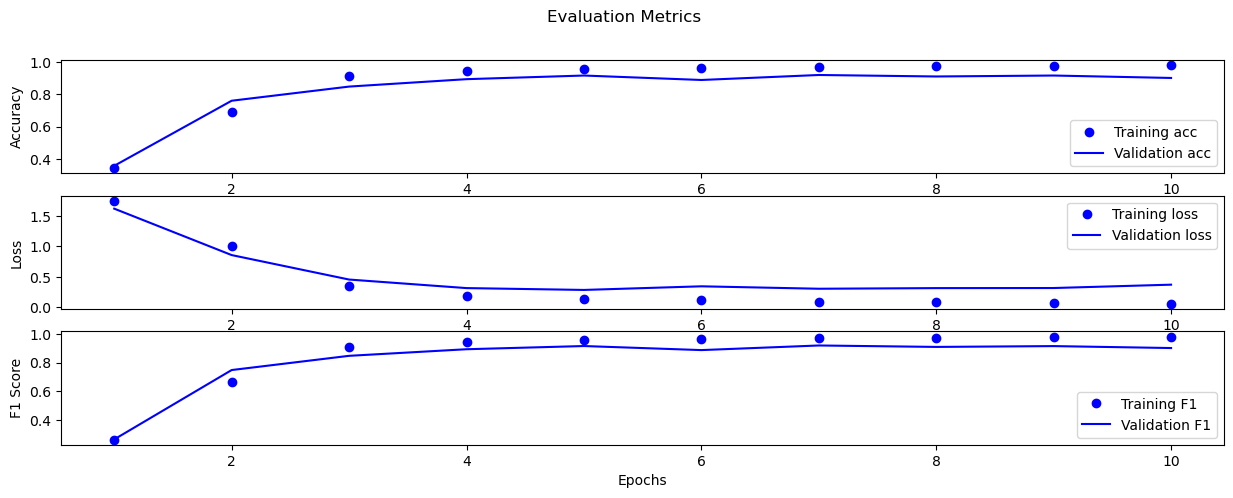

In [82]:
# define model architecture
model = Sequential([
    Embedding(1000, 32, input_shape = (1000, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFcountVec1000)

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 1000, 64)          64000     
                                                                 
 flatten_24 (Flatten)        (None, 64000)             0         
                                                                 
 dense_188 (Dense)           (None, 128)               8192128   
                                                                 
 dense_189 (Dense)           (None, 64)                8256      
                                                                 
 dense_190 (Dense)           (None, 7)                 455       
                                                                 
Total params: 8,264,839
Trainable params: 8,264,839
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
54/54 [========================

'Internal validation accuracy: 91.0%'

'Internal validation F1 score: 0.9103'

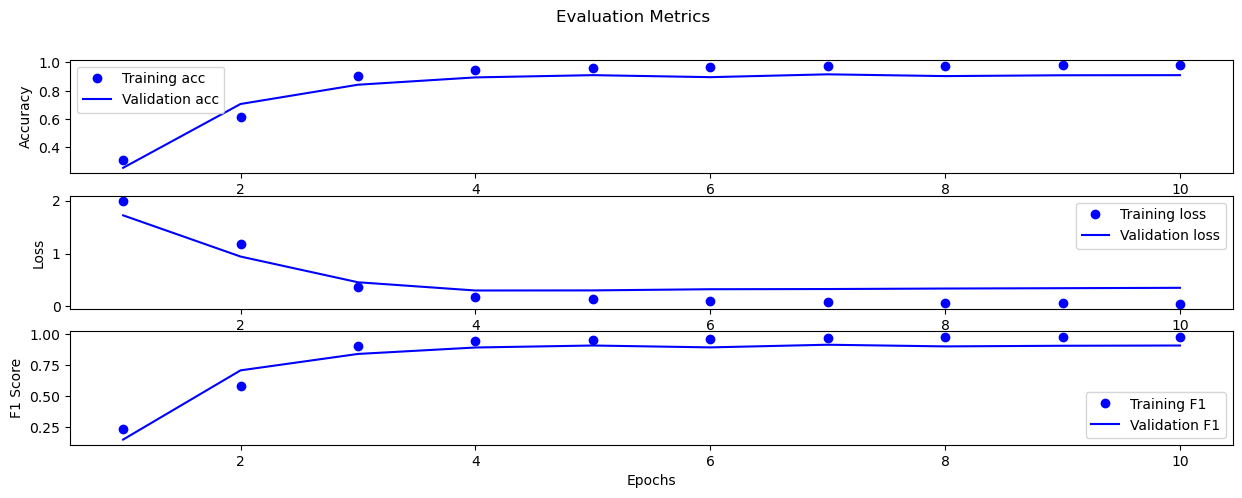

In [83]:
# define model architecture
model = Sequential([
    Embedding(1000, 64, input_shape = (1000, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFcountVec1000)

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 1000, 128)         128000    
                                                                 
 flatten_25 (Flatten)        (None, 128000)            0         
                                                                 
 dense_191 (Dense)           (None, 128)               16384128  
                                                                 
 dense_192 (Dense)           (None, 64)                8256      
                                                                 
 dense_193 (Dense)           (None, 7)                 455       
                                                                 
Total params: 16,520,839
Trainable params: 16,520,839
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
54/54 [======================

'Internal validation accuracy: 90.58%'

'Internal validation F1 score: 0.906'

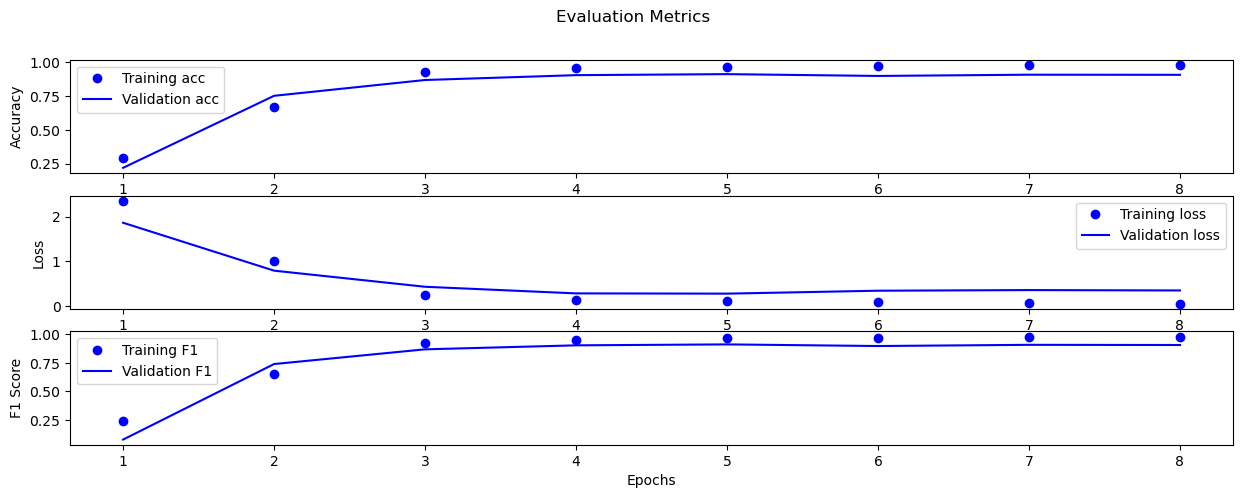

In [84]:
# define model architecture
model = Sequential([
    Embedding(1000, 128, input_shape = (1000, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFcountVec1000)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 4880, 64)          312320    
                                                                 
 flatten_13 (Flatten)        (None, 312320)            0         
                                                                 
 dense_105 (Dense)           (None, 128)               39977088  
                                                                 
 dense_106 (Dense)           (None, 64)                8256      
                                                                 
 dense_107 (Dense)           (None, 7)                 455       
                                                                 
Total params: 40,298,119
Trainable params: 40,298,119
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
54/54 [======================

'Internal validation accuracy: 91.67%'

'Internal validation F1 score: 0.917'

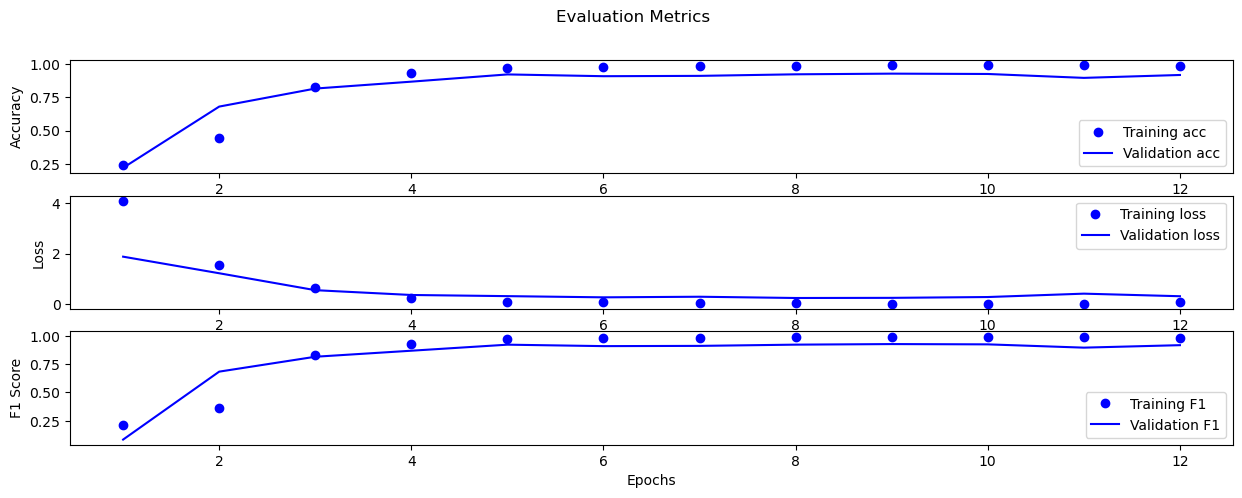

In [47]:
# define model architecture
model = Sequential([
    Embedding(4880, 64, input_shape = (4880, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtfidfVec)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 1000, 8)           8000      
                                                                 
 flatten_14 (Flatten)        (None, 8000)              0         
                                                                 
 dense_108 (Dense)           (None, 128)               1024128   
                                                                 
 dense_109 (Dense)           (None, 64)                8256      
                                                                 
 dense_110 (Dense)           (None, 7)                 455       
                                                                 
Total params: 1,040,839
Trainable params: 1,040,839
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
54/54 [========================

'Internal validation accuracy: 91.25%'

'Internal validation F1 score: 0.9134'

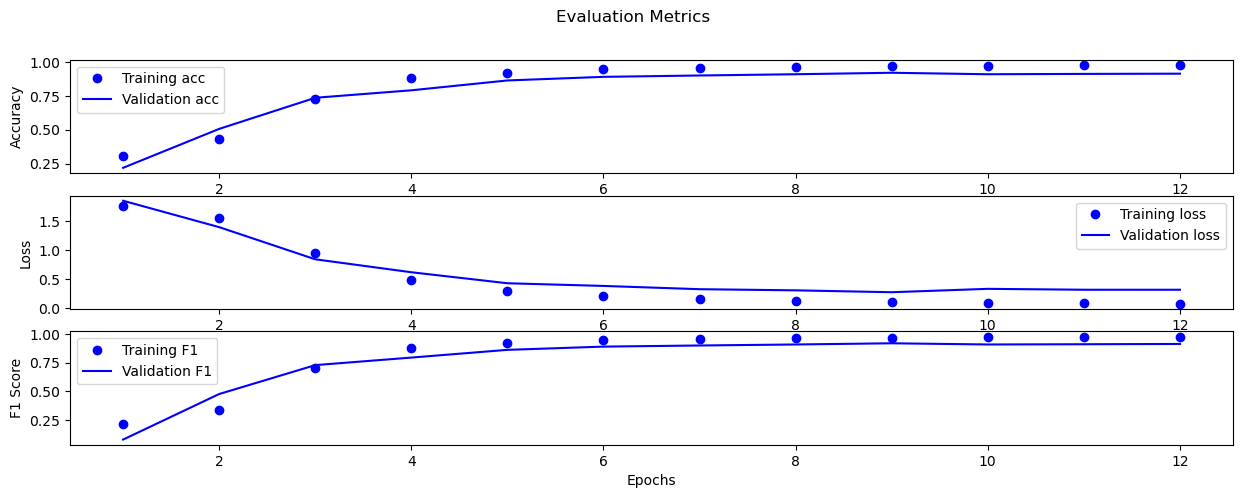

In [48]:
# define model architecture
model = Sequential([
    Embedding(1000, 8, input_shape = (1000, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtfidfVec1000)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 1000, 16)          16000     
                                                                 
 flatten_15 (Flatten)        (None, 16000)             0         
                                                                 
 dense_111 (Dense)           (None, 128)               2048128   
                                                                 
 dense_112 (Dense)           (None, 64)                8256      
                                                                 
 dense_113 (Dense)           (None, 7)                 455       
                                                                 
Total params: 2,072,839
Trainable params: 2,072,839
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
54/54 [========================

'Internal validation accuracy: 24.92%'

'Internal validation F1 score: 0.0994'

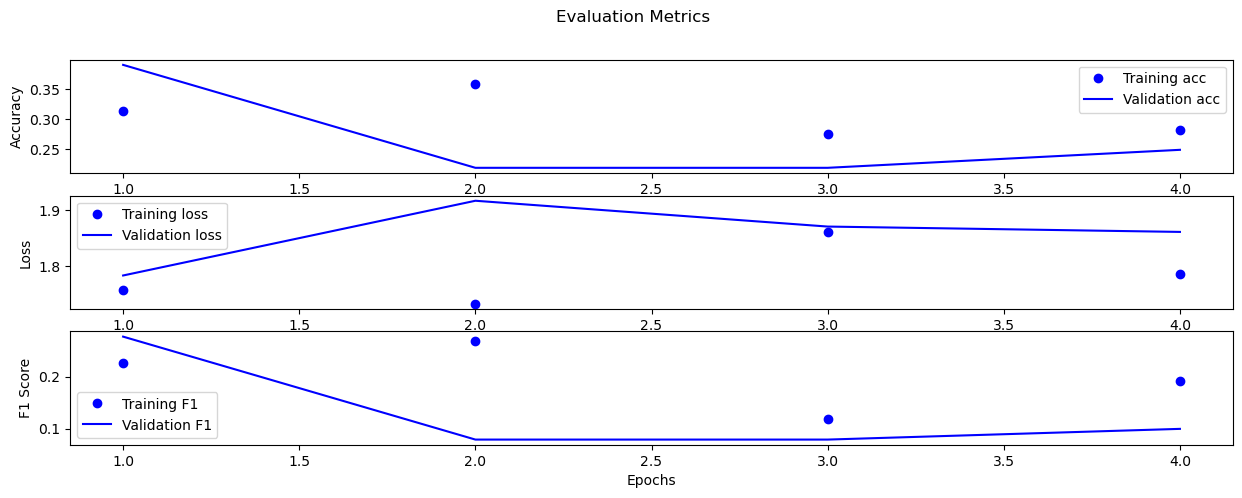

In [49]:
# define model architecture
model = Sequential([
    Embedding(1000, 16, input_shape = (1000, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtfidfVec1000)

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 1000, 32)          32000     
                                                                 
 flatten_16 (Flatten)        (None, 32000)             0         
                                                                 
 dense_114 (Dense)           (None, 128)               4096128   
                                                                 
 dense_115 (Dense)           (None, 64)                8256      
                                                                 
 dense_116 (Dense)           (None, 7)                 455       
                                                                 
Total params: 4,136,839
Trainable params: 4,136,839
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
54/54 [========================

'Internal validation accuracy: 24.92%'

'Internal validation F1 score: 0.0994'

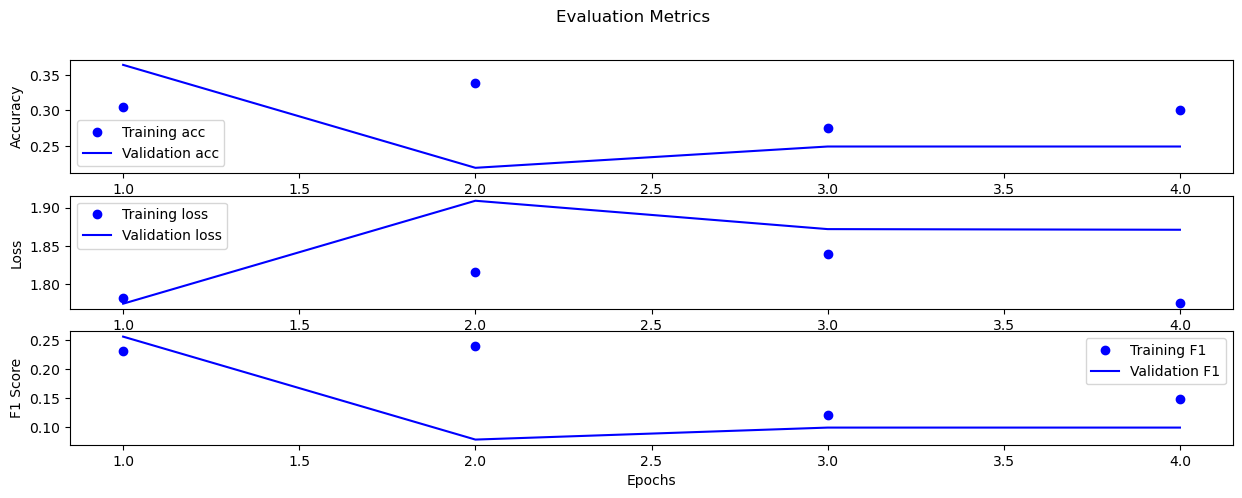

In [50]:
# define model architecture
model = Sequential([
    Embedding(1000, 32, input_shape = (1000, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtfidfVec1000)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 1000, 64)          64000     
                                                                 
 flatten_17 (Flatten)        (None, 64000)             0         
                                                                 
 dense_117 (Dense)           (None, 128)               8192128   
                                                                 
 dense_118 (Dense)           (None, 64)                8256      
                                                                 
 dense_119 (Dense)           (None, 7)                 455       
                                                                 
Total params: 8,264,839
Trainable params: 8,264,839
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
54/54 [========================

'Internal validation accuracy: 90.5%'

'Internal validation F1 score: 0.9051'

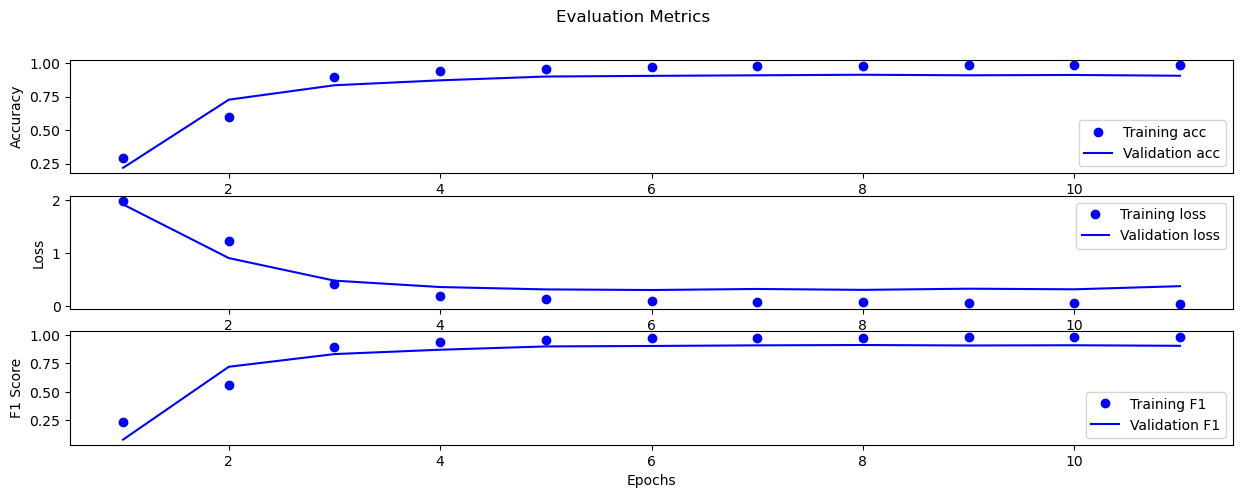

In [51]:
# define model architecture
model = Sequential([
    Embedding(1000, 64, input_shape = (1000, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtfidfVec1000)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 1000, 128)         128000    
                                                                 
 flatten_18 (Flatten)        (None, 128000)            0         
                                                                 
 dense_120 (Dense)           (None, 128)               16384128  
                                                                 
 dense_121 (Dense)           (None, 64)                8256      
                                                                 
 dense_122 (Dense)           (None, 7)                 455       
                                                                 
Total params: 16,520,839
Trainable params: 16,520,839
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
54/54 [======================

'Internal validation accuracy: 90.58%'

'Internal validation F1 score: 0.9065'

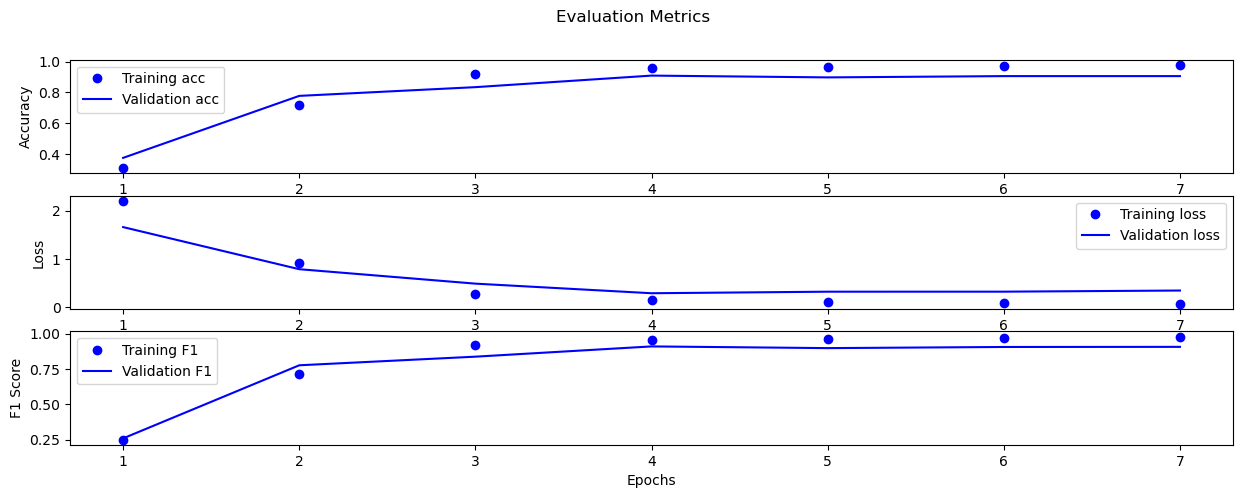

In [52]:
# define model architecture
model = Sequential([
    Embedding(1000, 128, input_shape = (1000, )),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFtfidfVec1000)

### RNNs

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 50, 8)             400       
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1312      
                                                                 
 dense_123 (Dense)           (None, 7)                 231       
                                                                 
Total params: 1,943
Trainable params: 1,943
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
54/54 [==============================] - 66s 1s/step - loss: 1.7415 - accuracy: 0.3347 - f1_score: 0.2797 - val_loss: 1.9058 - val_accuracy: 0.2525 - val_f1_score: 0.2338
Epoch 2/100
54/54 [==============================] - 62s 1s/step - loss: 1.5397 - accuracy: 0.4684 - f1_score: 0.4249 - val_loss: 1.

'Internal validation accuracy: 57.0%'

'Internal validation F1 score: 0.5652'

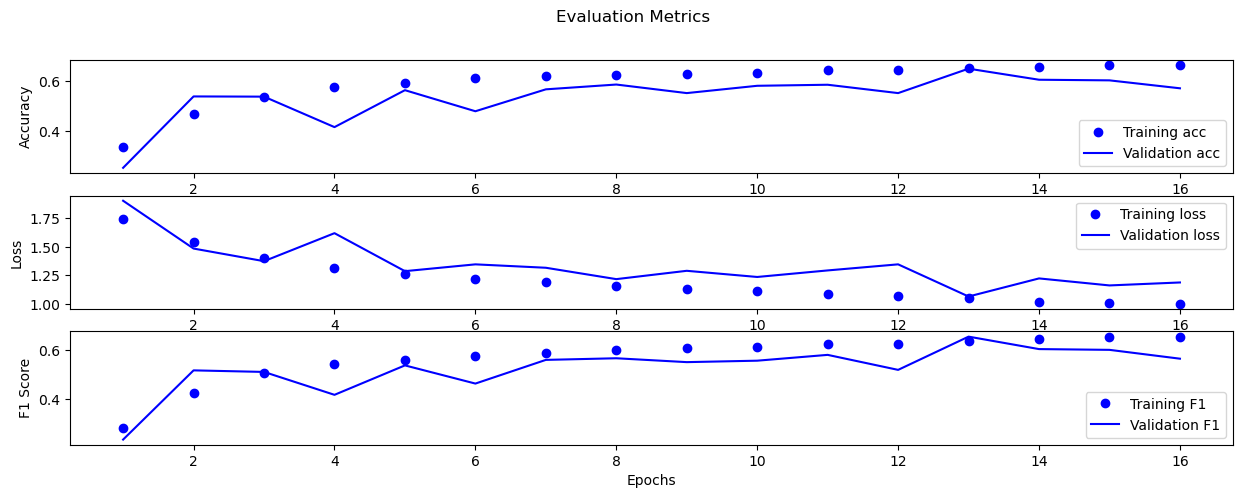

In [53]:
# define model architecture
model = Sequential([
    Embedding(50, 8, input_shape = (50, )),
    SimpleRNN(32),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 50, 8)             400       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 32)            1312      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 32)            2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_124 (Dense)           (None, 7)                 231       
                                                                 
Total params: 6,103
Trainable params: 6,103
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
54/54 [==============================] 

'Internal validation accuracy: 53.33%'

'Internal validation F1 score: 0.5478'

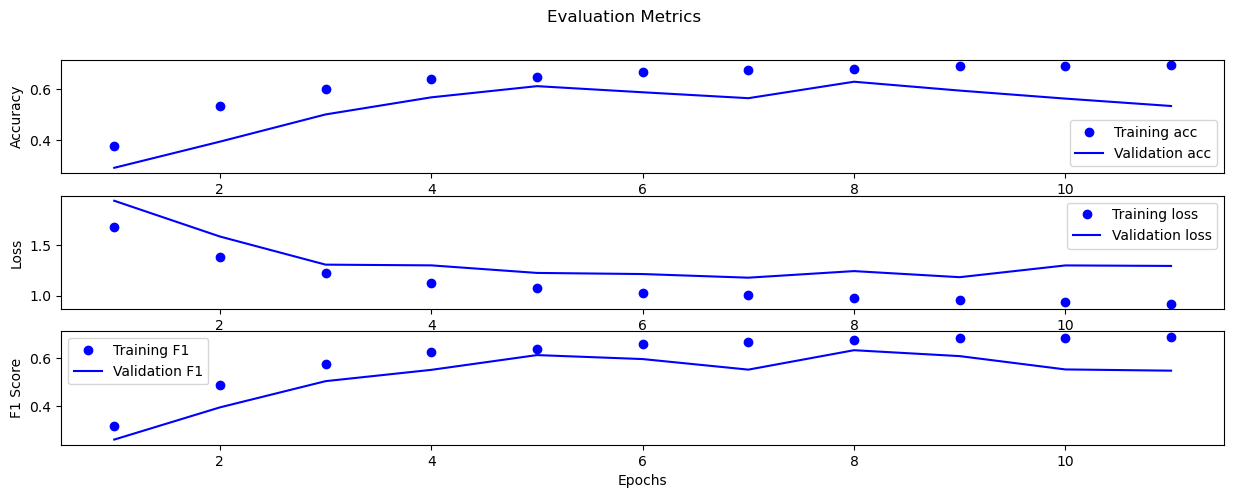

In [54]:
# define model architecture
model = Sequential([
    Embedding(50, 8, input_shape = (50, )),
    SimpleRNN(32, return_sequences = True),
    SimpleRNN(32, return_sequences = True),
    SimpleRNN(32),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 50, 16)            800       
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 50, 32)            1568      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 50, 32)            2080      
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 50, 32)            2080      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_125 (Dense)           (None, 7)                 231       
                                                                 
Total params: 8,839
Trainable params: 8,839
Non-train

'Internal validation accuracy: 57.42%'

'Internal validation F1 score: 0.5715'

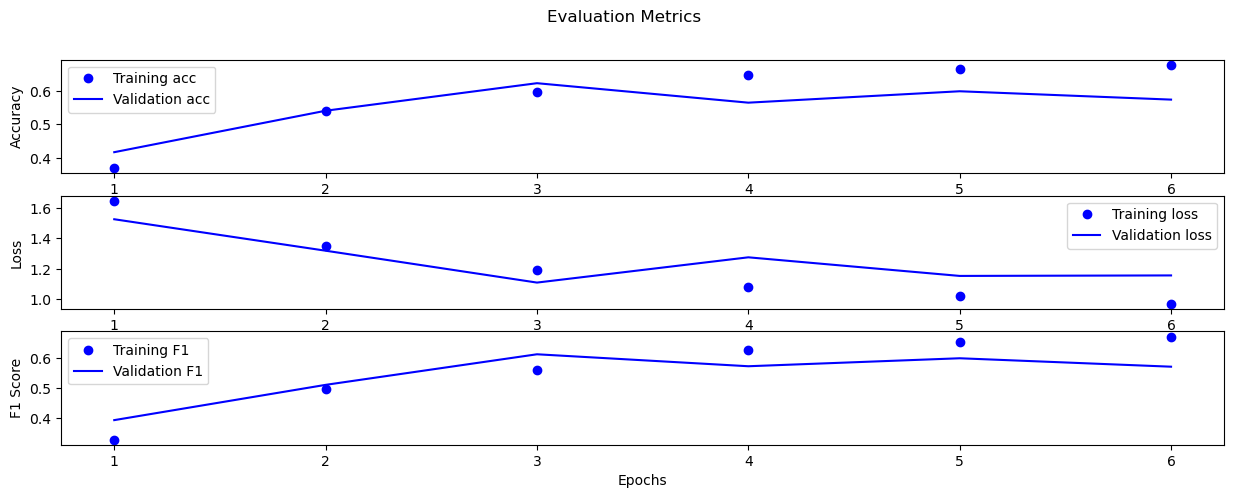

In [55]:
# define model architecture
model = Sequential([
    Embedding(50, 16, input_shape = (50, )),
    SimpleRNN(32, return_sequences = True),
    SimpleRNN(32, return_sequences = True),
    SimpleRNN(32, return_sequences = True),
    SimpleRNN(32),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 50, 16)            800       
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 50, 32)            1568      
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 50, 32)            2080      
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 50, 32)            2080      
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 50, 32)            2080      
                                                                 
 flatten_19 (Flatten)        (None, 1600)              0         
                                                                 
 dense_126 (Dense)           (None, 64)              

'Internal validation accuracy: 65.0%'

'Internal validation F1 score: 0.664'

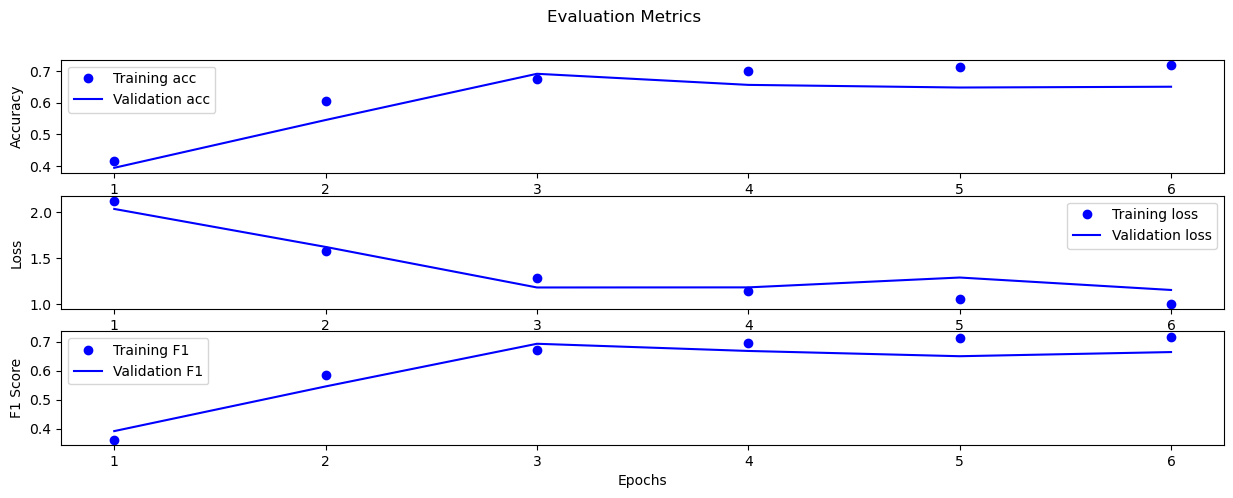

In [56]:
# define penalty hyperparameter
PENALTY = 0.005

# define model architecture
model = Sequential([
    Embedding(50, 16, input_shape = (50, )),
    SimpleRNN(32, return_sequences = True),
    SimpleRNN(32, return_sequences = True),
    SimpleRNN(32, return_sequences = True),
    SimpleRNN(32, return_sequences = True),
    Flatten(),
    Dense(64, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(16, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 50, 16)            800       
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 16)                528       
                                                                 
 dense_129 (Dense)           (None, 128)               2176      
                                                                 
 dense_130 (Dense)           (None, 64)                8256      
                                                                 
 dense_131 (Dense)           (None, 7)                 455       
                                                                 
Total params: 12,215
Trainable params: 12,215
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
54/54 [==============================

'Internal validation accuracy: 54.67%'

'Internal validation F1 score: 0.5232'

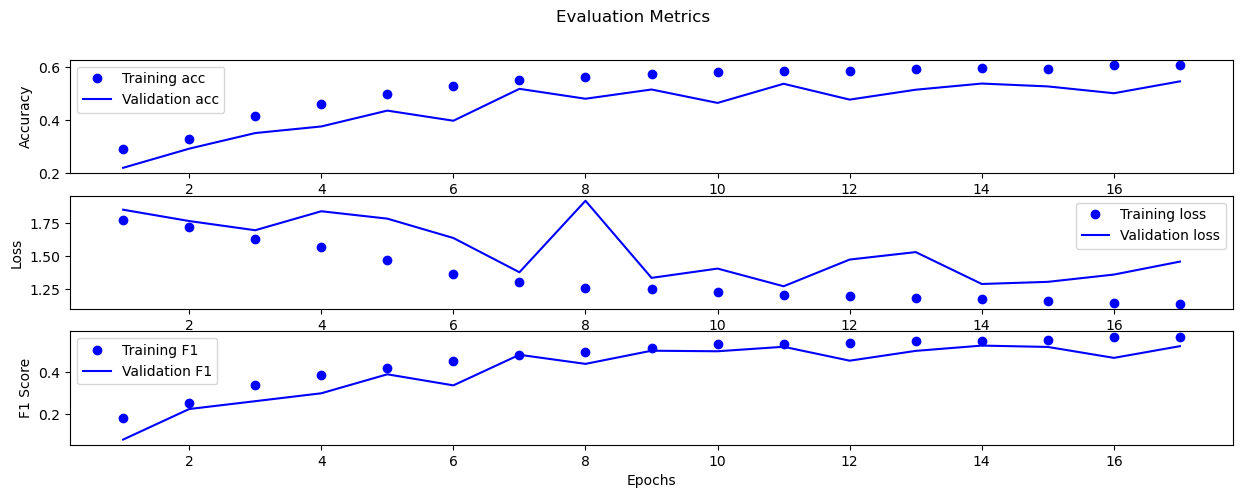

In [57]:
# define model architecture
model = Sequential([
    Embedding(50, 16, input_shape = (50, )),
    SimpleRNN(16),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 50, 64)            3200      
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 32)                3104      
                                                                 
 dense_132 (Dense)           (None, 128)               4224      
                                                                 
 dense_133 (Dense)           (None, 64)                8256      
                                                                 
 dense_134 (Dense)           (None, 7)                 455       
                                                                 
Total params: 19,239
Trainable params: 19,239
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
54/54 [==============================

'Internal validation accuracy: 35.92%'

'Internal validation F1 score: 0.238'

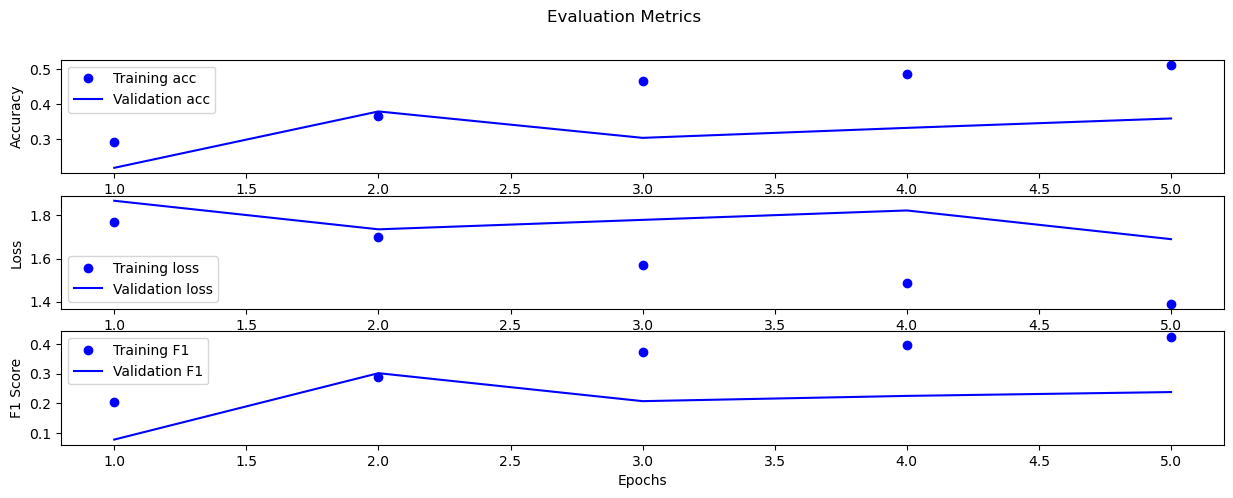

In [58]:
# define model architecture
model = Sequential([
    Embedding(50, 64, input_shape = (50, )),
    SimpleRNN(32),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(7, activation = 'softmax')
])

# evaluate model
EvaluateModel(model, trainDFintVec)